## Prepare observations: convolution, clip

We want to downgrade all the observations to the lowest resolution (300 km/s) and clip the wavelength range to [4023,6000] A

Load the modules and define the format of the plots

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader
from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange
from sbi import utils as Ut
from sbi import inference as Inference

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)
mpl.rcParams["mathtext.fontset"]='dejavuserif'

Load the observational data from individual files

In [22]:
files= sorted(os.listdir('obs'))[1:]
waves=[]
fluxes=[]
sigma_gal=[]
for f in files[1:]:
    data=np.loadtxt('./obs/'+f)
    waves.append(data[:,0])
    fluxes.append(data[:,1])
    arr=np.array([float(f[6:12]),float(f[13:19])])
    sigma_gal.append(np.mean(arr))

Inspect the data

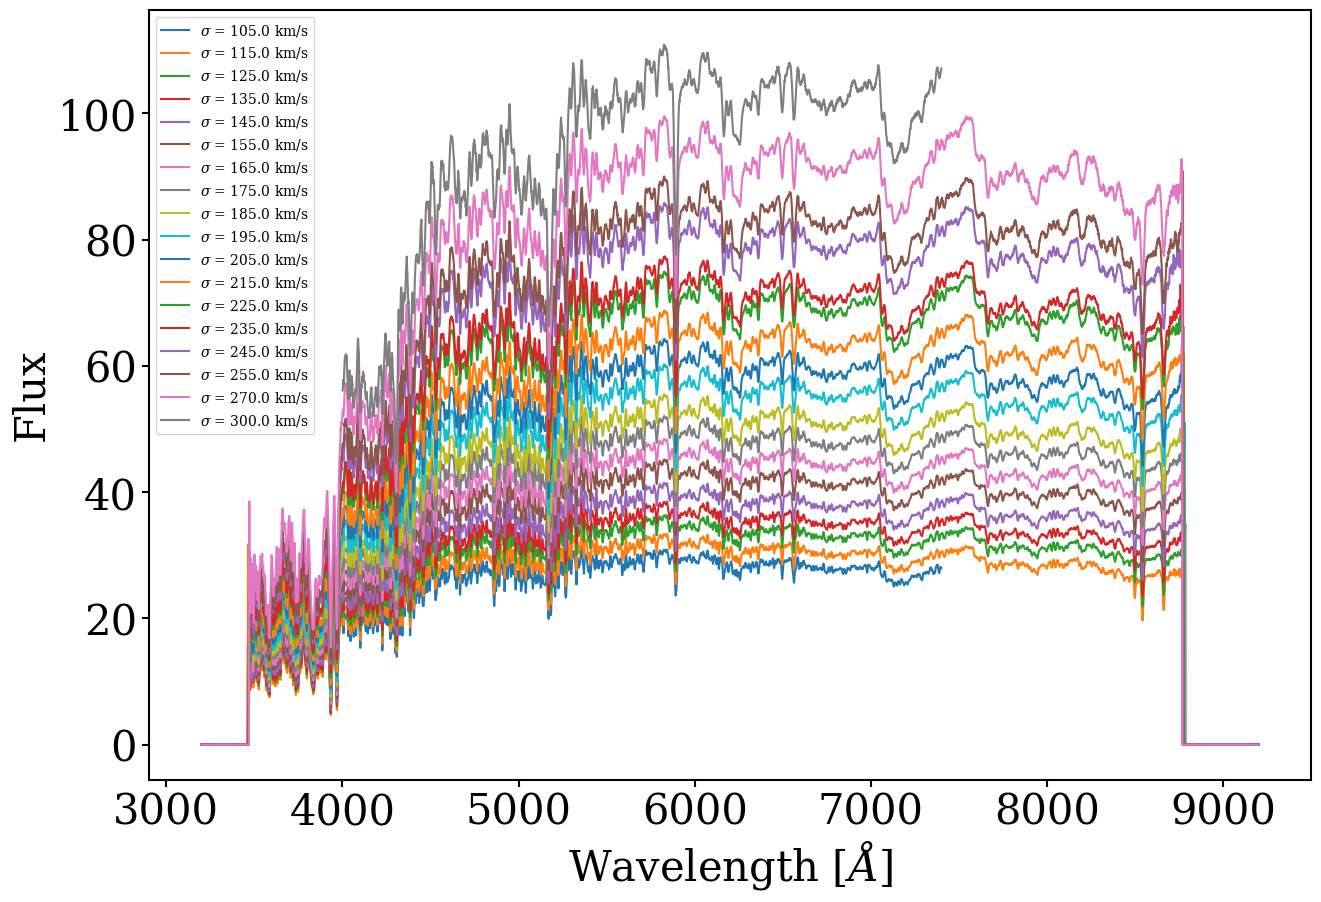

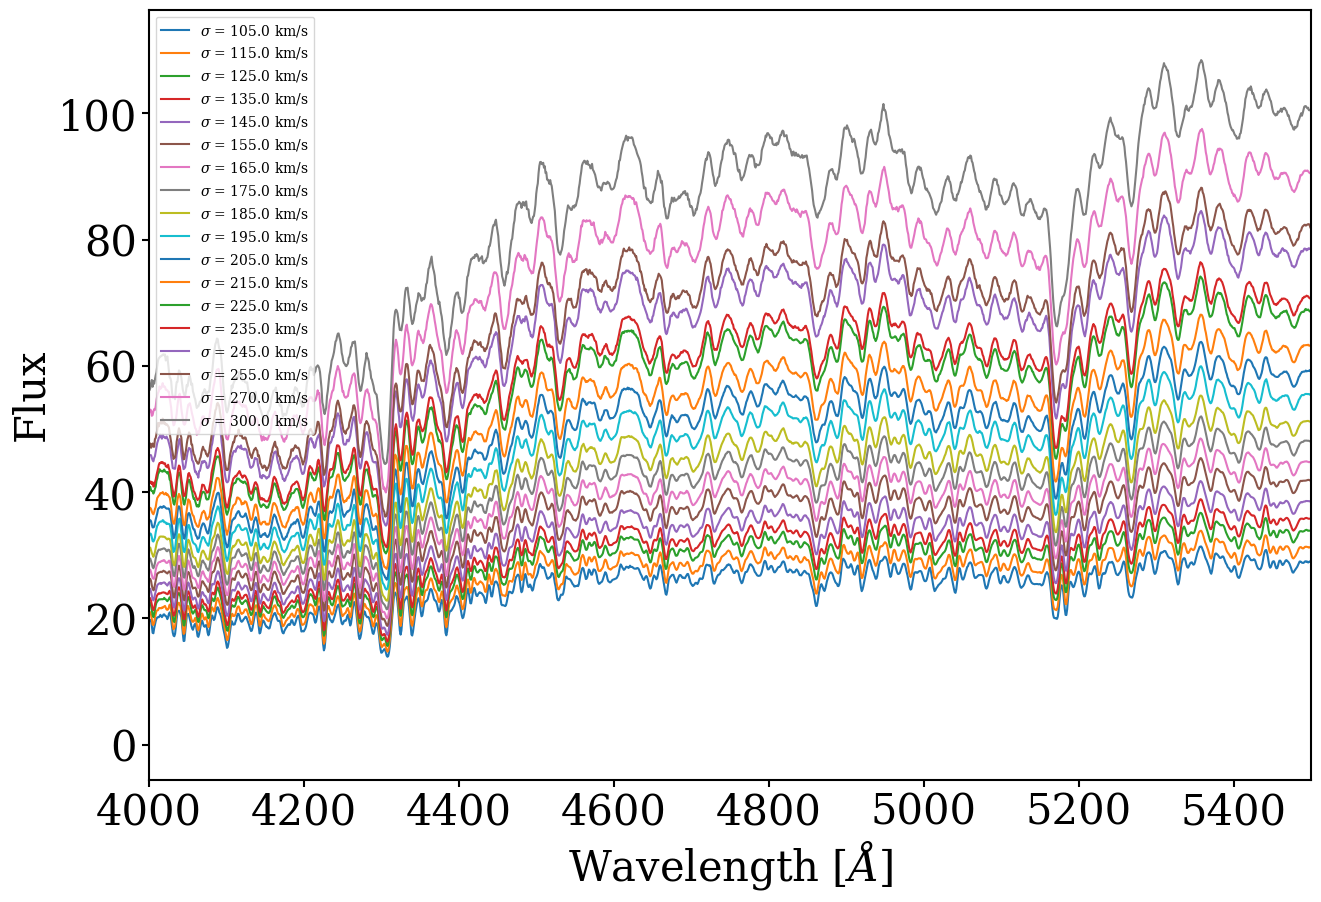

In [5]:
n=len(fluxes)

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend(fontsize=10)
plt.show()


"""for i in range(n):
    print(np.min(waves[i]),np.max(waves[i]))"""

#largest wavelength range from 4000 to 7400 but we will limit ourselves to the range from 4000 to 5500"

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.xlim(4000,5500)
plt.legend(fontsize=10)
plt.show()


Limit wavelength range

In [ ]:
fluxes_short=[]
waves_short=[]

for i in range(n):
    ind=np.where((waves[i]>3999)&(waves[i]<7401))[0]
    fluxes_short.append(fluxes[i][ind])
    waves_short.append(waves[i][ind])

Downgrade each spectrum to the lowest resolution (300 km/s)


$$ \sigma_{gal}^2=\sigma_{v}^2+\sigma_{ins}^2$$

We are going to convert all of them to $v=300$ km/s, so:

$$ \sigma_{diff}^2 = \sigma_{300}^2+\sigma_{ins}^2 - (\sigma_{gal}^2+\sigma_{ins}^2) = \sigma_{300}^2 - \sigma_{gal}^2   $$

And to move from velocity dispersion to kernel width, we will need unit conversions and:

$$
\mathrm{FWHM}=2 \sqrt{2 \ln 2} \sigma \approx 2.35482 \sigma
$$

In [ ]:
def gaussian_filter1d(spec, sig):
    """
    Convolve a spectrum by a Gaussian with different sigma for every pixel.
    If all sigma are the same this routine produces the same output as
    scipy.ndimage.gaussian_filter1d, except for the border treatment.
    Here the first/last p pixels are filled with zeros.
    When creating  template library for SDSS data, this implementation
    is 60x faster than a naive for loop over pixels.
    :param spec: vector with the spectrum to convolve
    :param sig: vector of sigma values (in pixels) for every pixel
    :return: spec convolved with a Gaussian with dispersion sig
    """
    sig = sig.clip(0.01)  # forces zero sigmas to have 0.01 pixels
    p = int(np.ceil(np.max(3*sig)))
    m = 2*p + 1  # kernel size
    x2 = np.linspace(-p, p, m)**2
    n = spec.size
    a = np.zeros((m, n))
    for j in range(m):   # Loop over the small size of the kernel
        a[j, p:-p] = spec[j:n-m+j+1]
    gau = np.exp(-x2[:, None]/(2*sig**2))
    gau /= np.sum(gau, 0)[None, :]  # Normalize kernel
    conv_spectrum = np.sum(a*gau, 0)
    return conv_spectrum

Apply the kernels to the observations

In [ ]:
cvel=300000 #km/s
psize=1 #delta_lambda of the observations
fluxes_conv=[]
max_sigma=np.sqrt(300**2 - np.array(sigma_gal)**2) #difference in velocity dispersion

for i in trange(n):
    #Perform unit conversion
    FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma[i] / cvel * waves_short[i]
    FWHM_dif = np.sqrt(FWHM_gal**2)
    sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels, for the kernel
    flux_conv = gaussian_filter1d(fluxes_short[i], sigma) 
    fluxes_conv.append(flux_conv)

#Plot two examples
for i in [0,-1]:
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',c='k',lw=2)
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


#Change wavelength range because of the change in resolution
waves_short_2 = []
fluxes_conv_2 = []

print('Selected wavelength range: ',waves_short[0][23],waves_short[0][2000])

for i in range(n):
    waves_short_2.append(waves_short[i][23:2001])
    fluxes_conv_2.append(fluxes_conv[i][23:2001])

Save processed spectra

In [ ]:
seds=[]
for i in range(18):
    seds.append(fluxes_conv_2[i]/np.median(fluxes_conv_2[i]))

np.save('./obs/processed/seds.npy',seds)
np.save('./obs/processed/wave.npy',waves_short_2[0])

Load processed spectra

In [23]:
#load convolved and clipped observations from stacks

seds=np.load('./obs/processed/seds.npy')

Plot processed spectra with a colormap based on the velocity dispersion

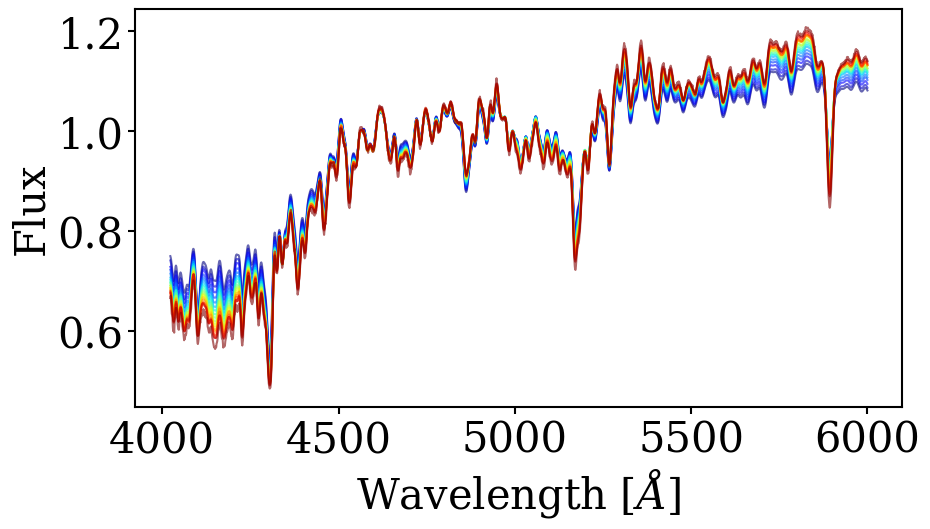

In [7]:
colors=plt.cm.jet(np.linspace(0,1,18))

plt.figure(figsize=(10,6))
colors=plt.cm.jet(np.linspace(0,1,18))
for i in range(18):
        plt.plot(range(4023,6001),seds[i],alpha=0.6,color=colors[i])
        plt.scatter(range(4023,6001),seds[i],marker='None',c=sigma_gal[i]*np.ones((len(range(4023,6001)),)),cmap='jet')
#plt.colorbar(label='$\\sigma$ [Km/s]')
#plt.clim(105,300)
plt.xlabel('Wavelength [$\\AA$]')
plt.ylabel('Flux')
#plt.legend()
plt.tight_layout()
#plt.savefig('./spectra_observations.jpeg')
plt.show()

Let's start predicting SFHs and metallicity for observations

In [24]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x):

        """ generate and organize data for training and testing"""

        self.x=torch.from_numpy(x) #seds
        

    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        return x


Load encoder model trained on synthetic data and generate latent representations for the observations

In [43]:
#create a pytorch dataset

dataset = Dataset(np.array(seds) )
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint_etg.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=10)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch.float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

FileNotFoundError: [Errno 2] No such file or directory: './saved_models/checkpoint_etg.pt'

Load Normalizing Flows model trained on synthetic data and predict posteriors for the observations sampled with 10.000 evaluations

In [26]:
file="./saved_models/my_posterior_etg.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

posteriors=[]


for i in tqdm(range(18)):
    posteriors.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)

100%|██████████| 18/18 [01:13<00:00,  4.09s/it]


Save median and standard deviations of the posteriors predicted for the observations

In [27]:
np.save('post_obs_median_ssfr.npy',np.median(posteriors,axis=0))
np.save('post_obs_stds_ssfr.npy',np.std(posteriors,axis=0))

Load median and standard deviations of the posteriors predicted for the observations

In [28]:
post_median=np.load('post_obs_median_ssfr.npy')
post_stds=np.load('post_obs_stds_ssfr.npy')

Function to obtain redshift from cosmic time for the plots

In [29]:
import astropy.units as u
from astropy.cosmology import  Planck13,z_at_value


def z(t):
    #receives cosmic time, returns redshit
    return np.around(z_at_value(Planck13.age,t*u.Gyr).value,1)
    
def t(z):
    #receives redsfit, returns cosmic time
    return (Planck13.age(0)-Planck13.lookback_time(z)).value

Plot percentile predictions

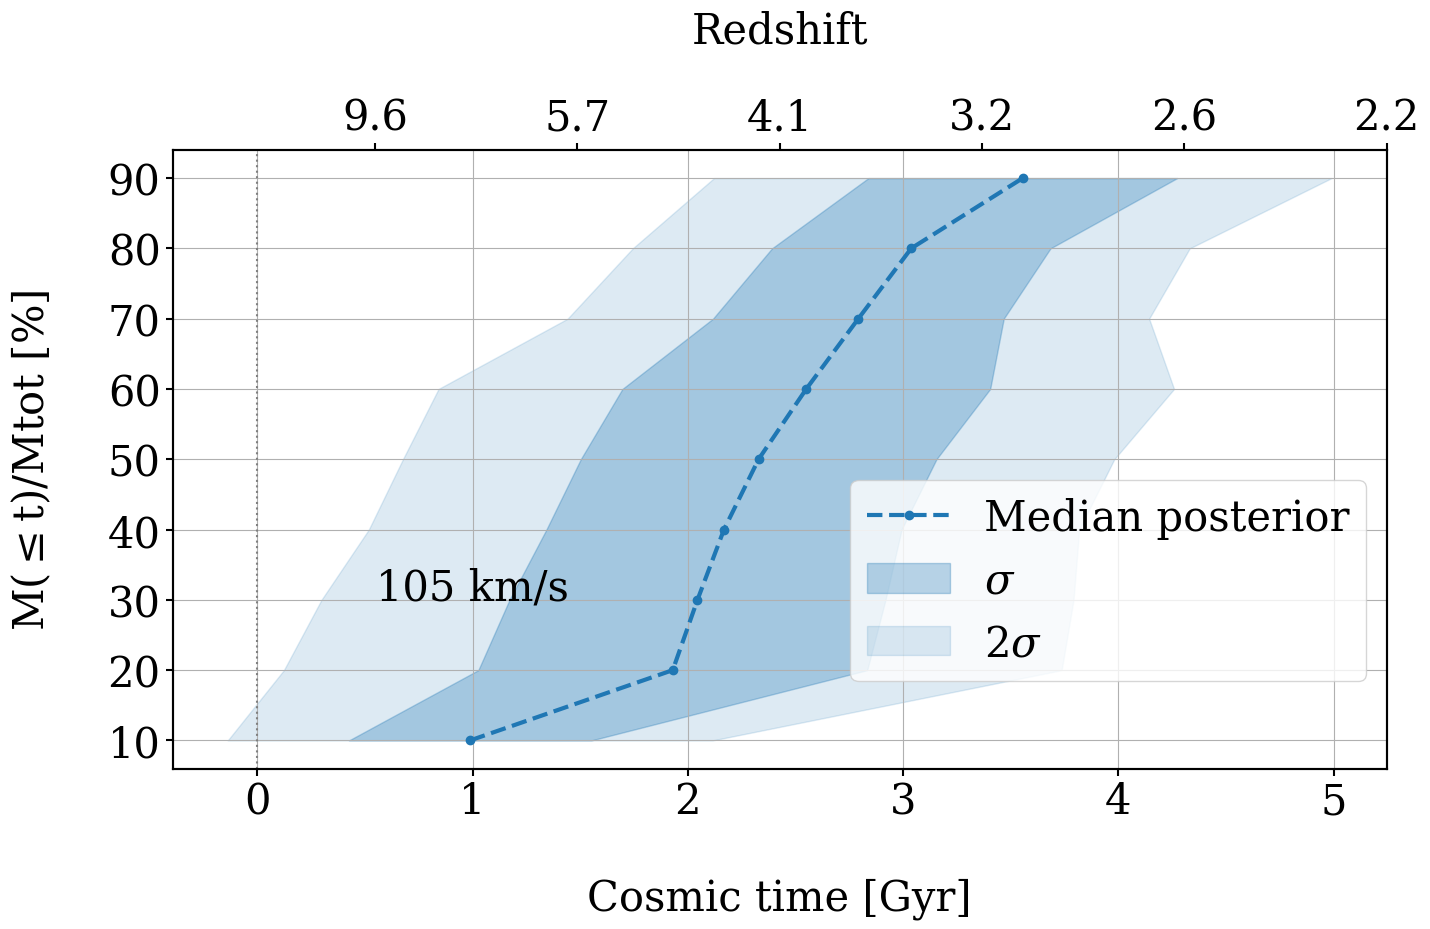

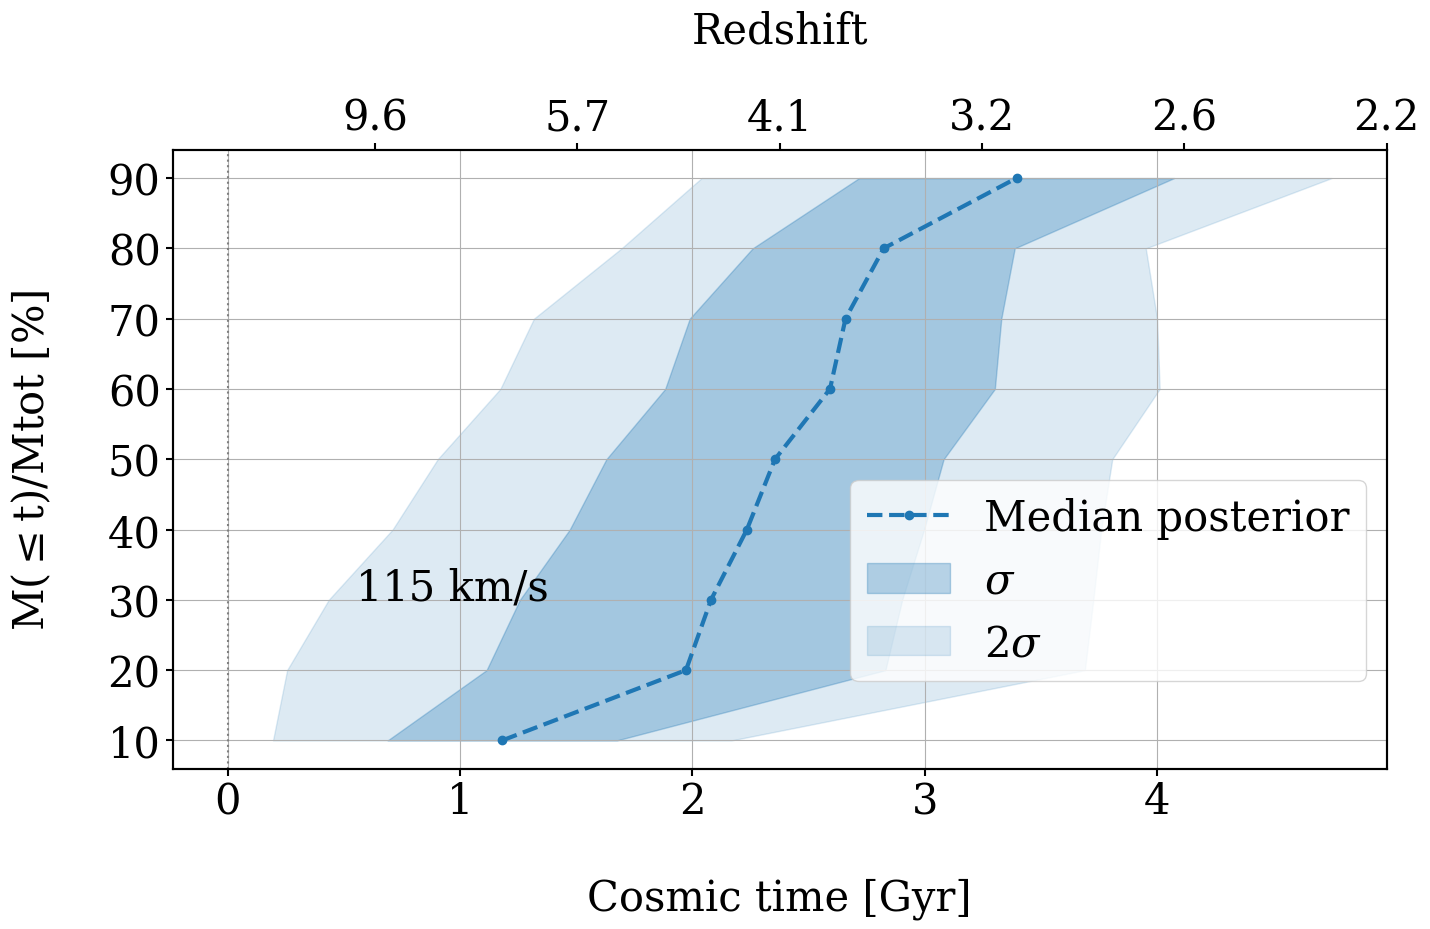

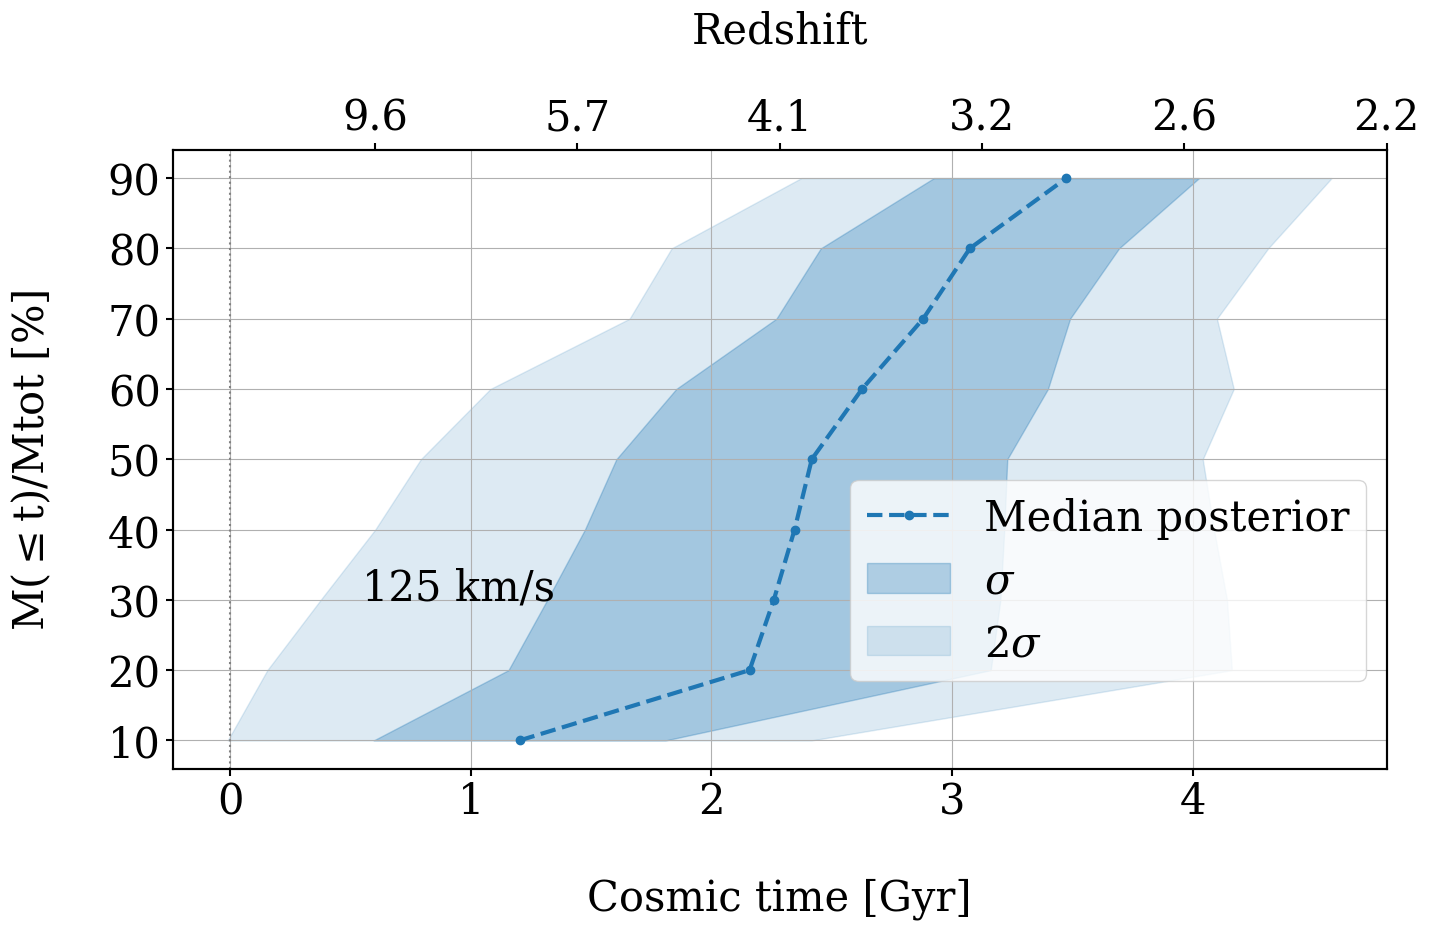

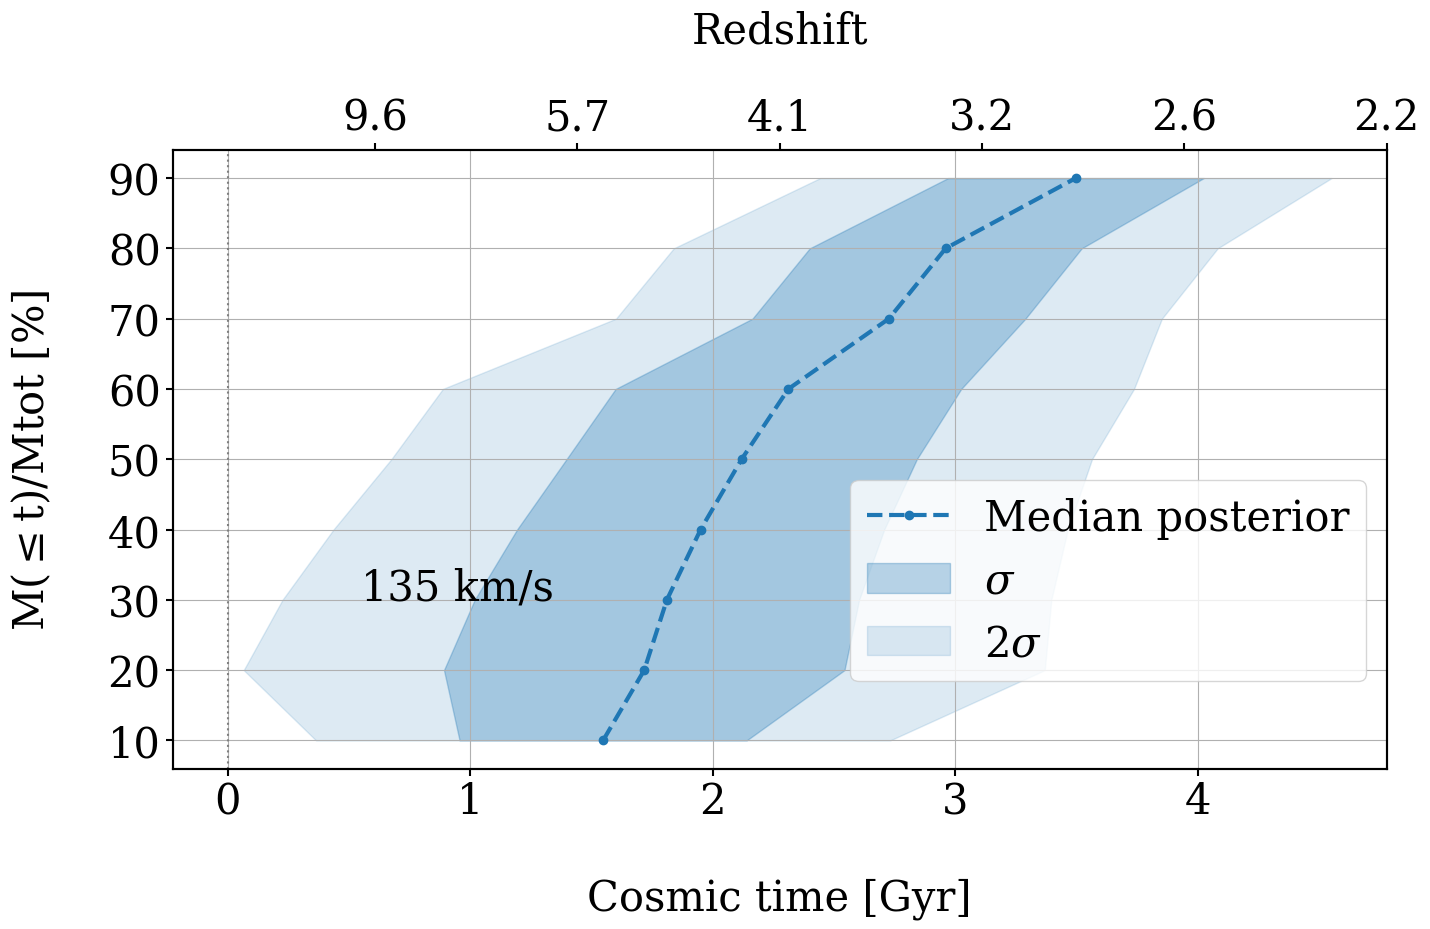

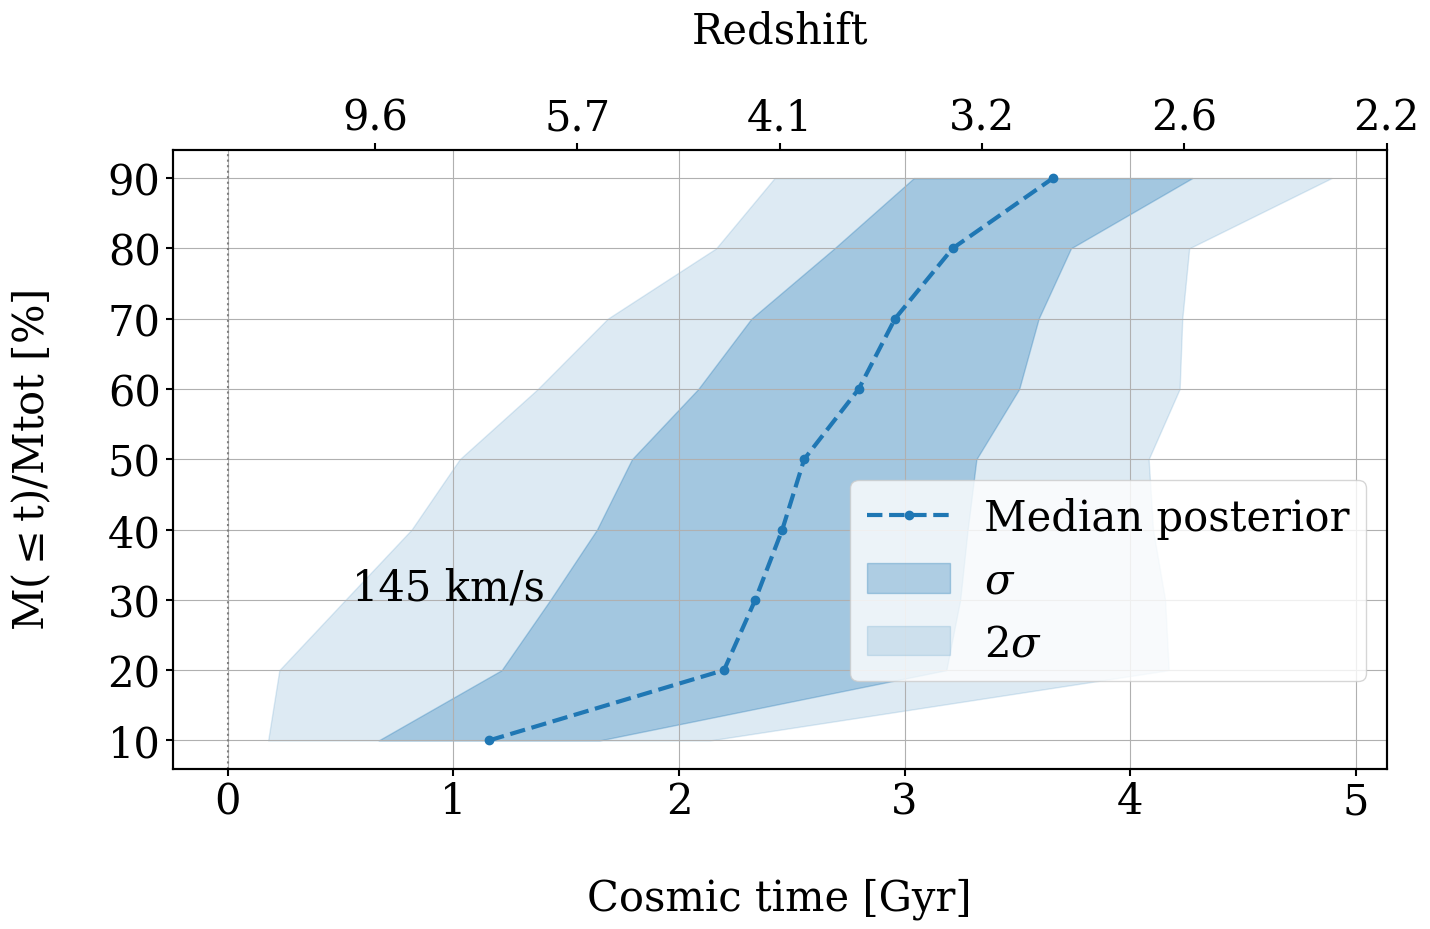

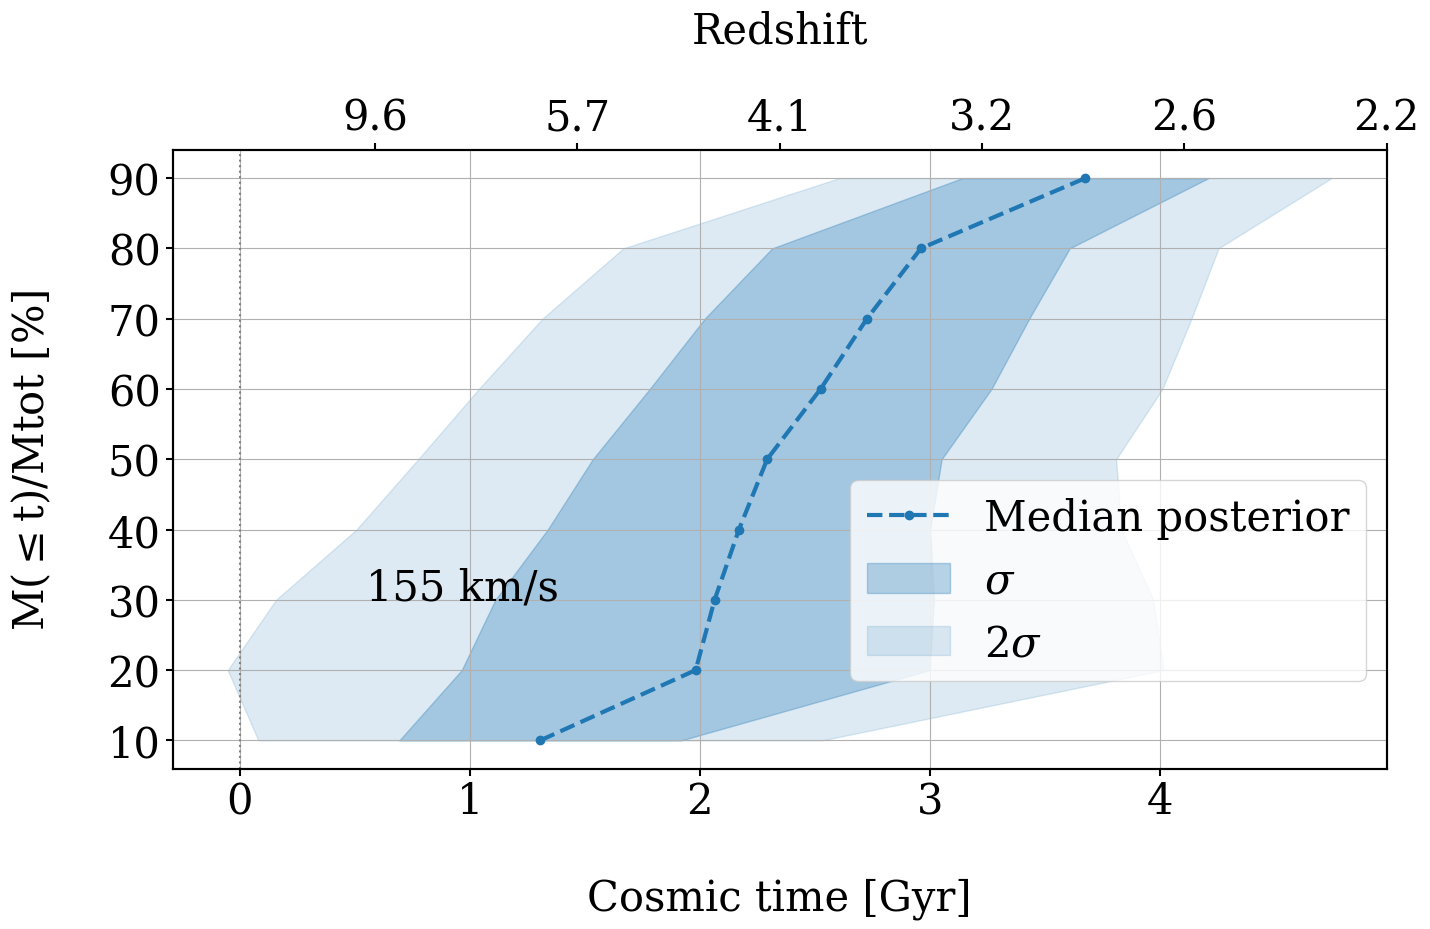

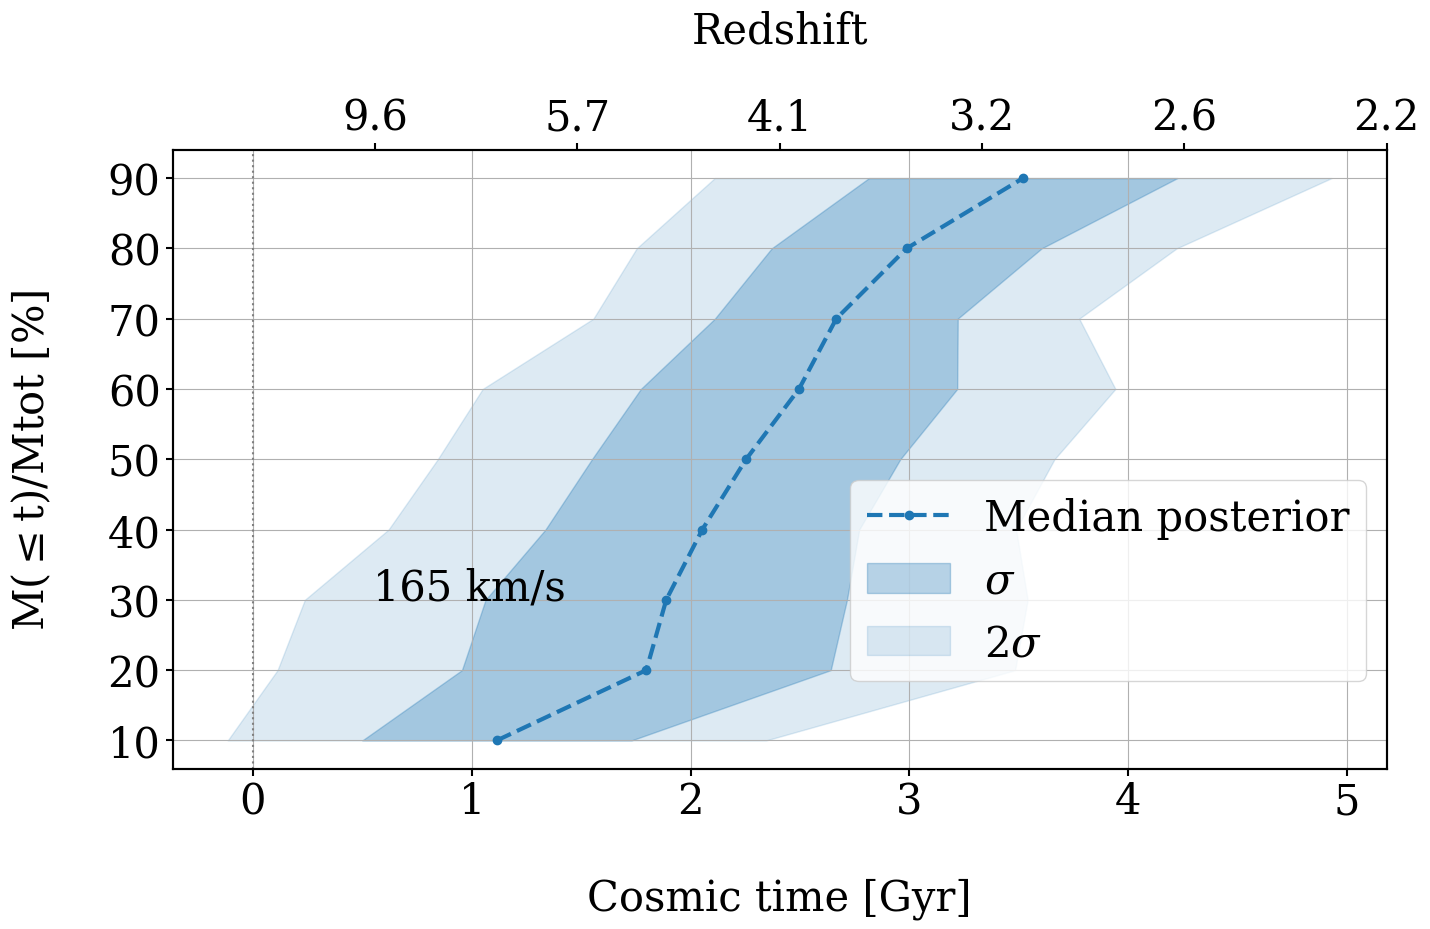

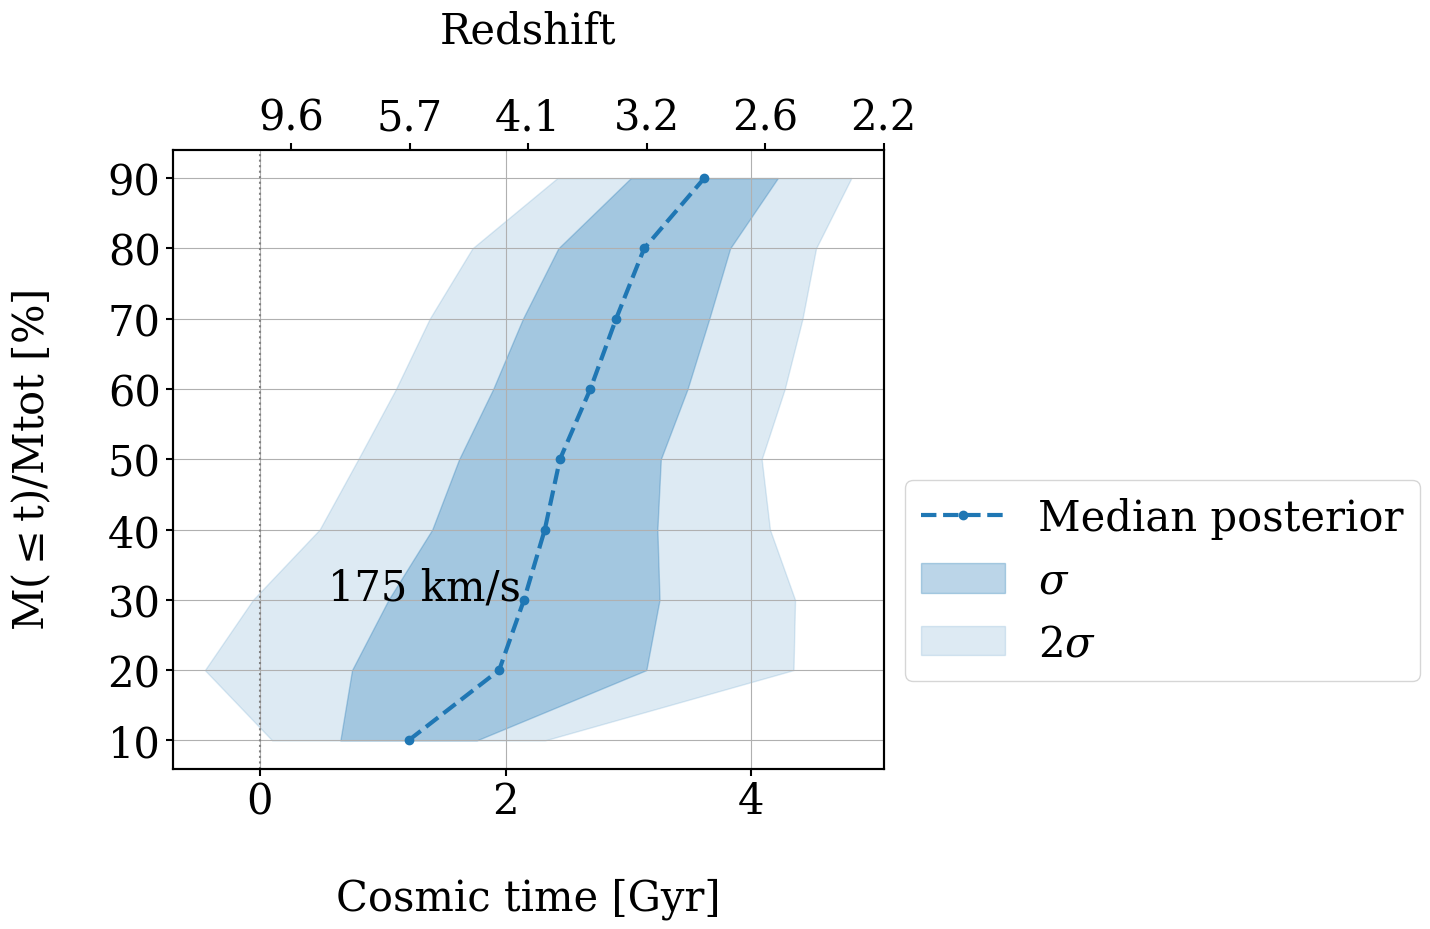

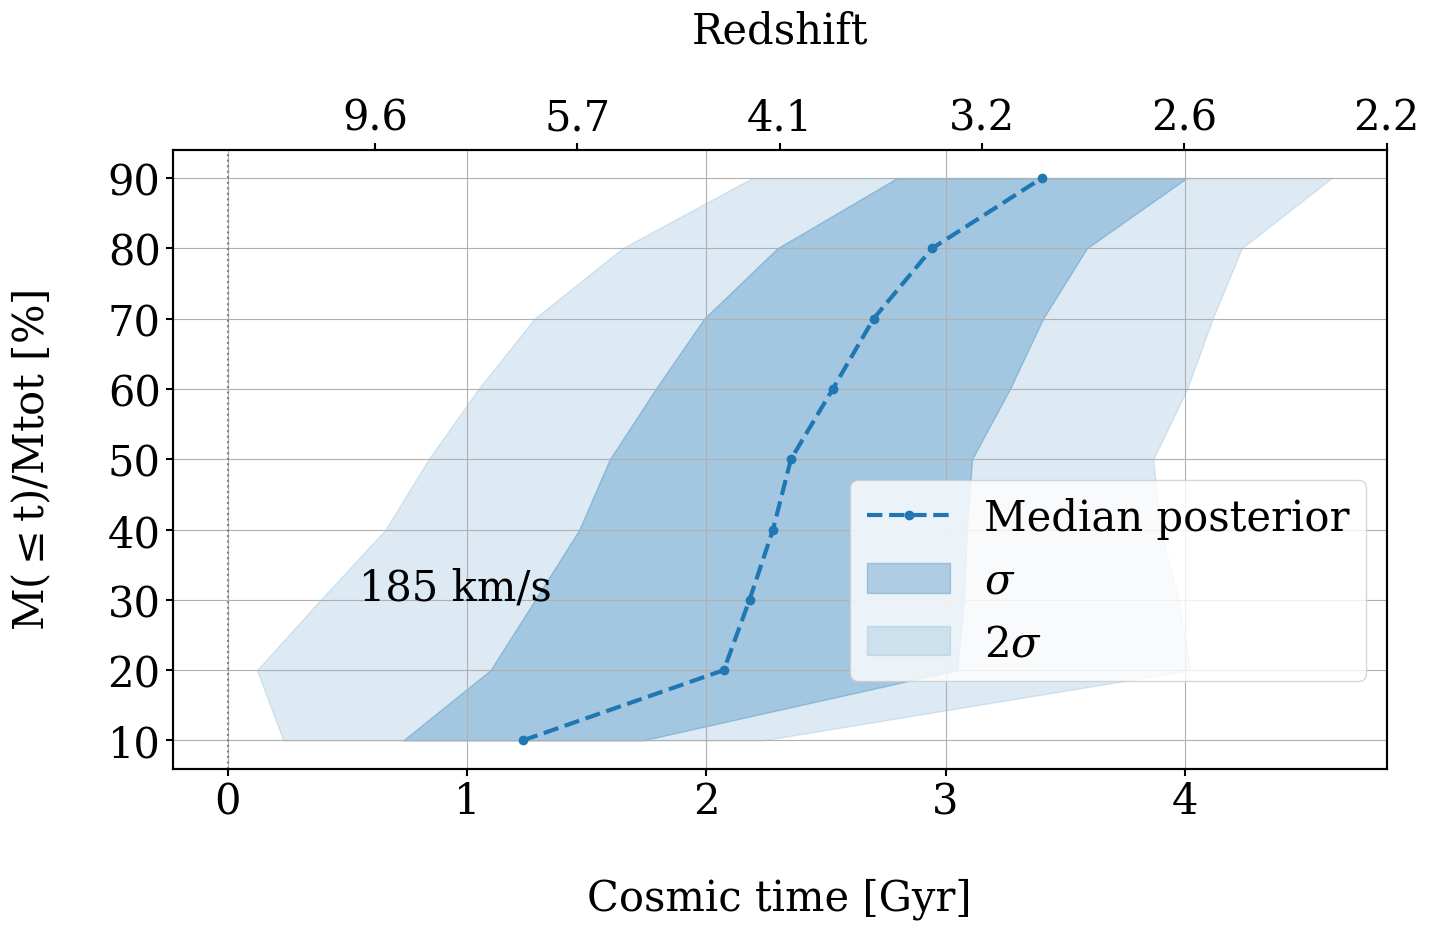

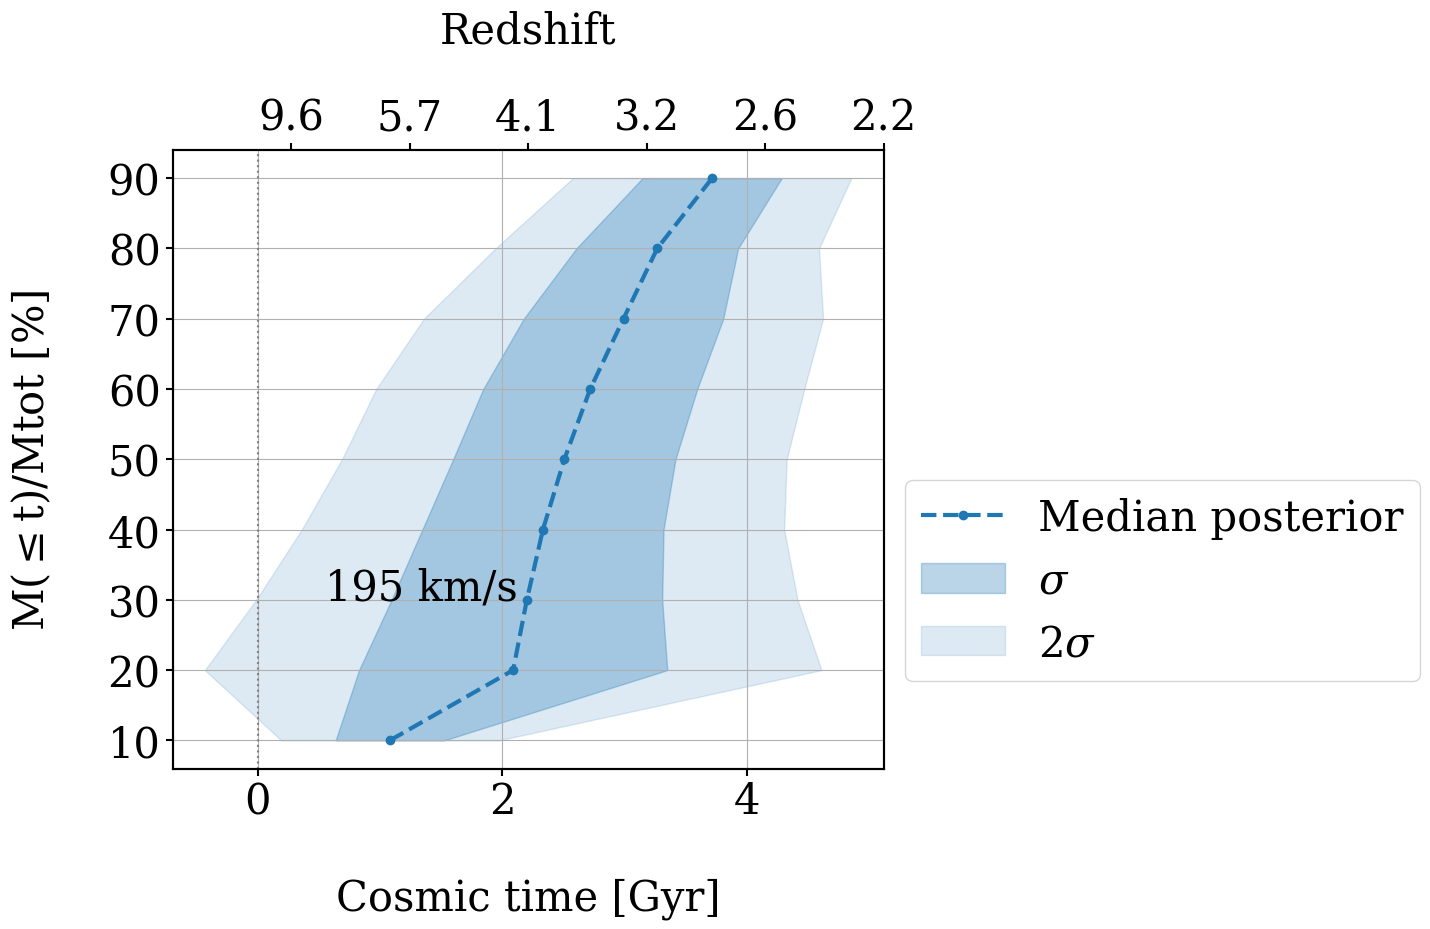

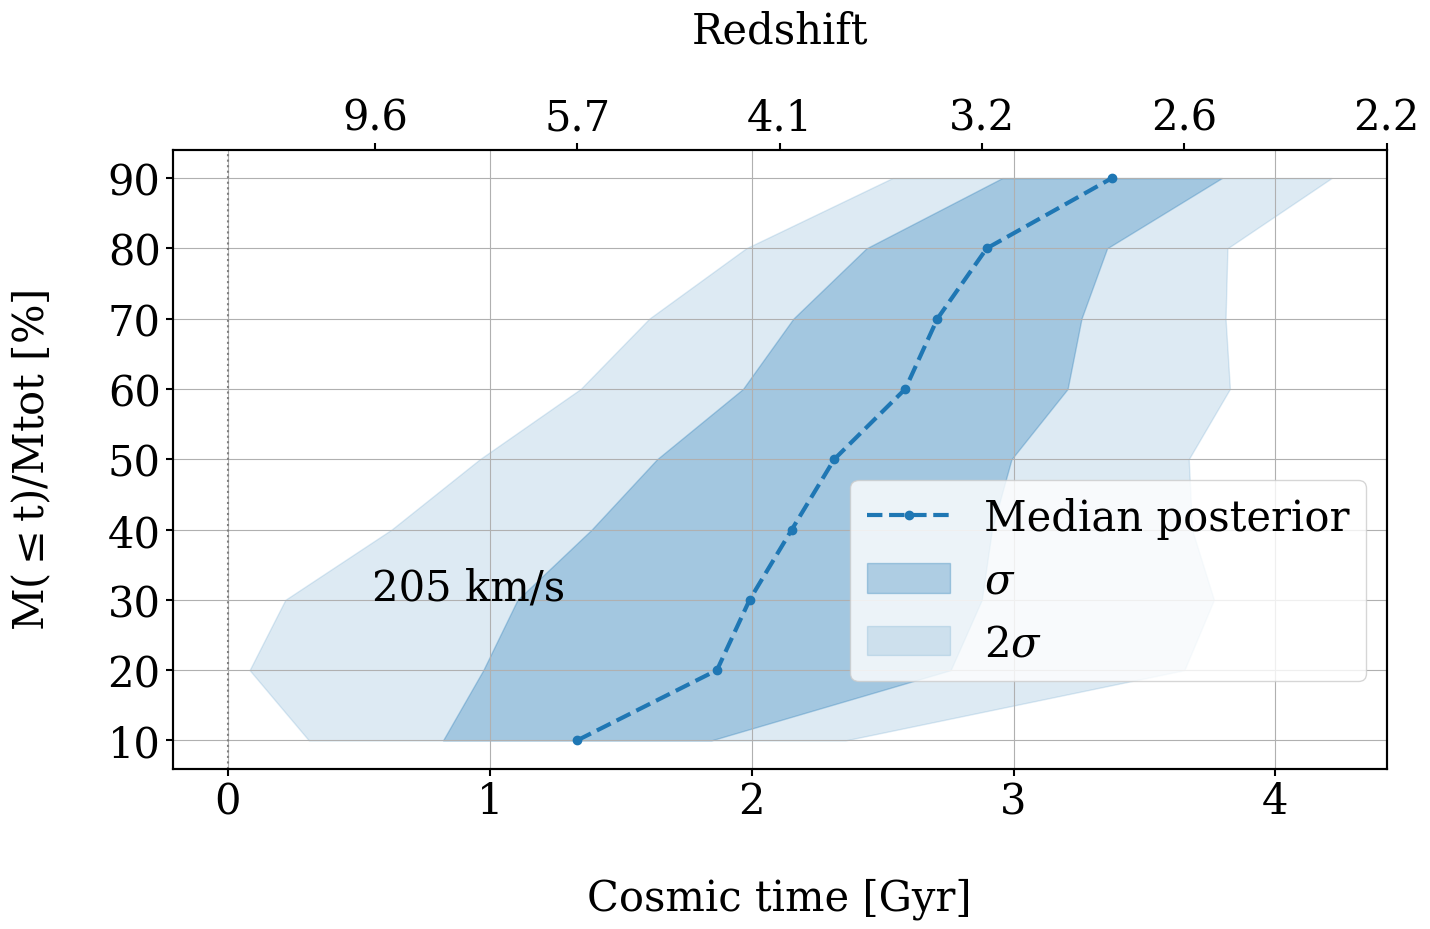

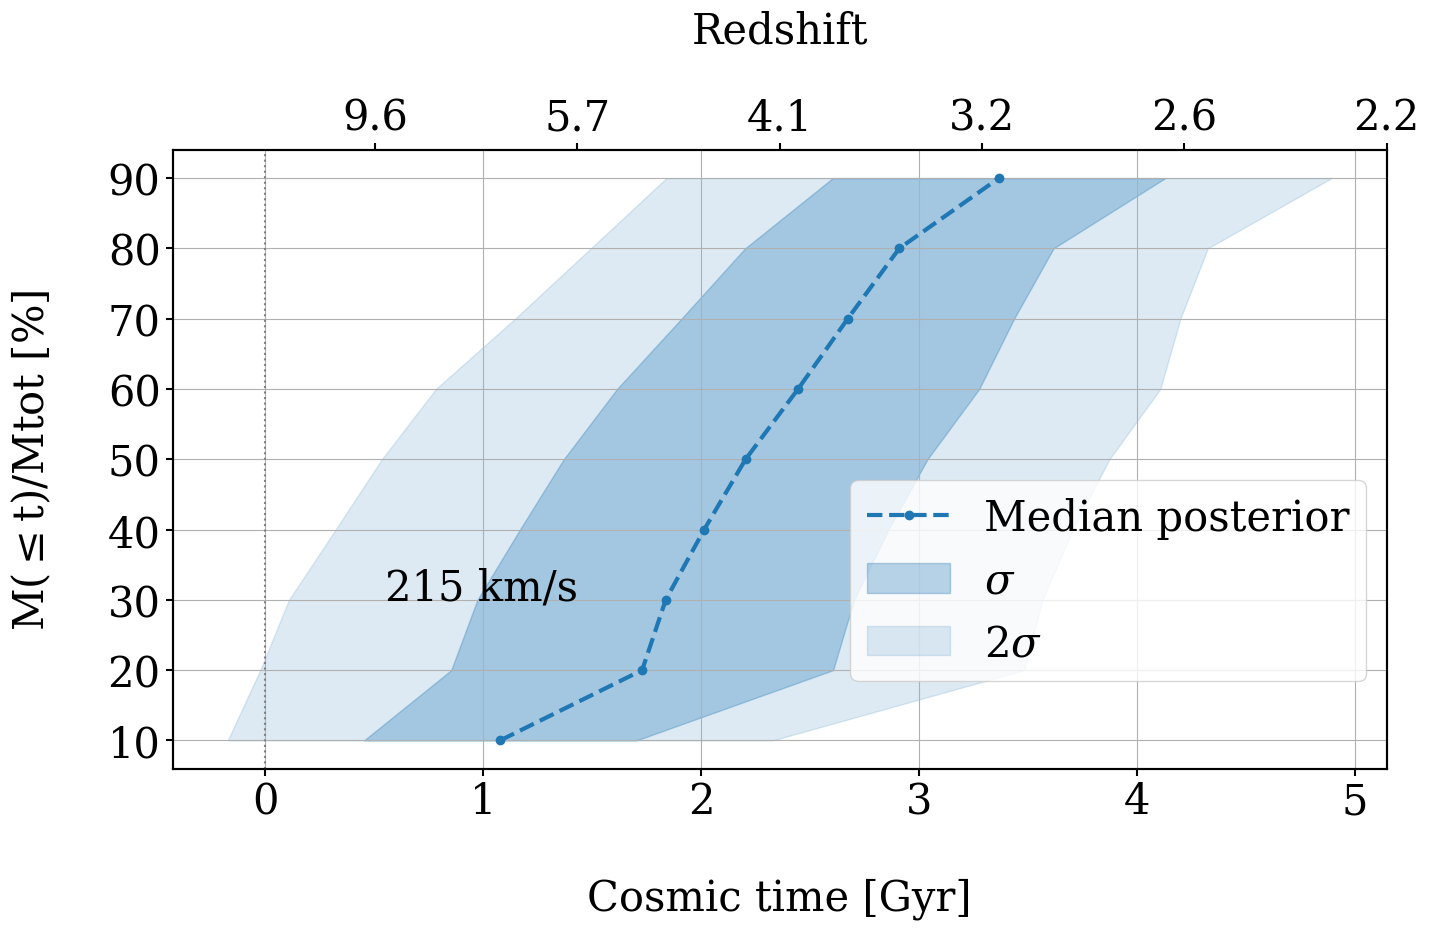

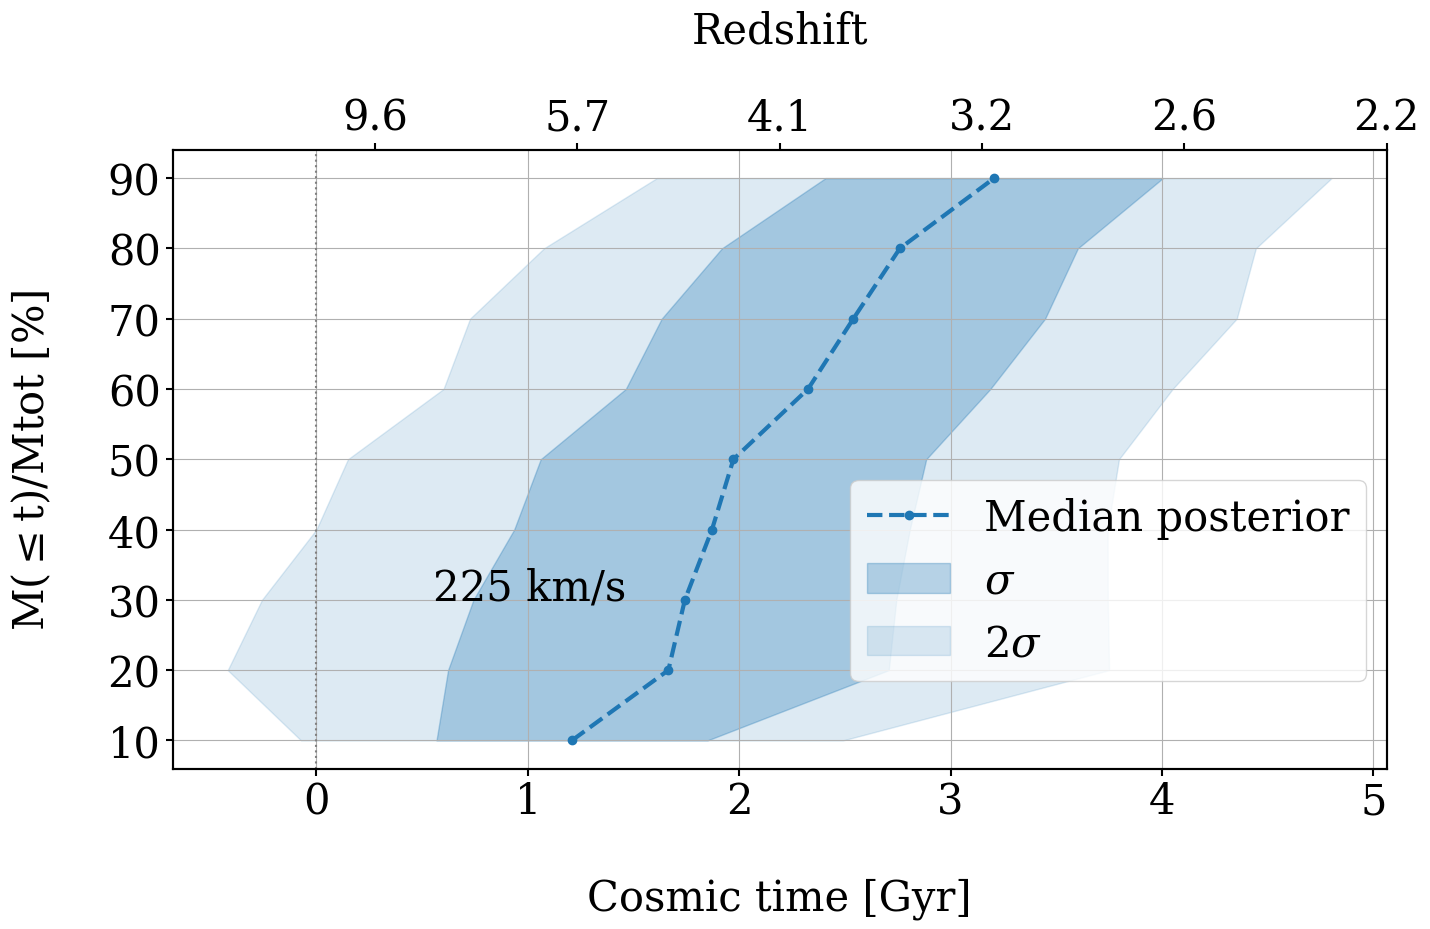

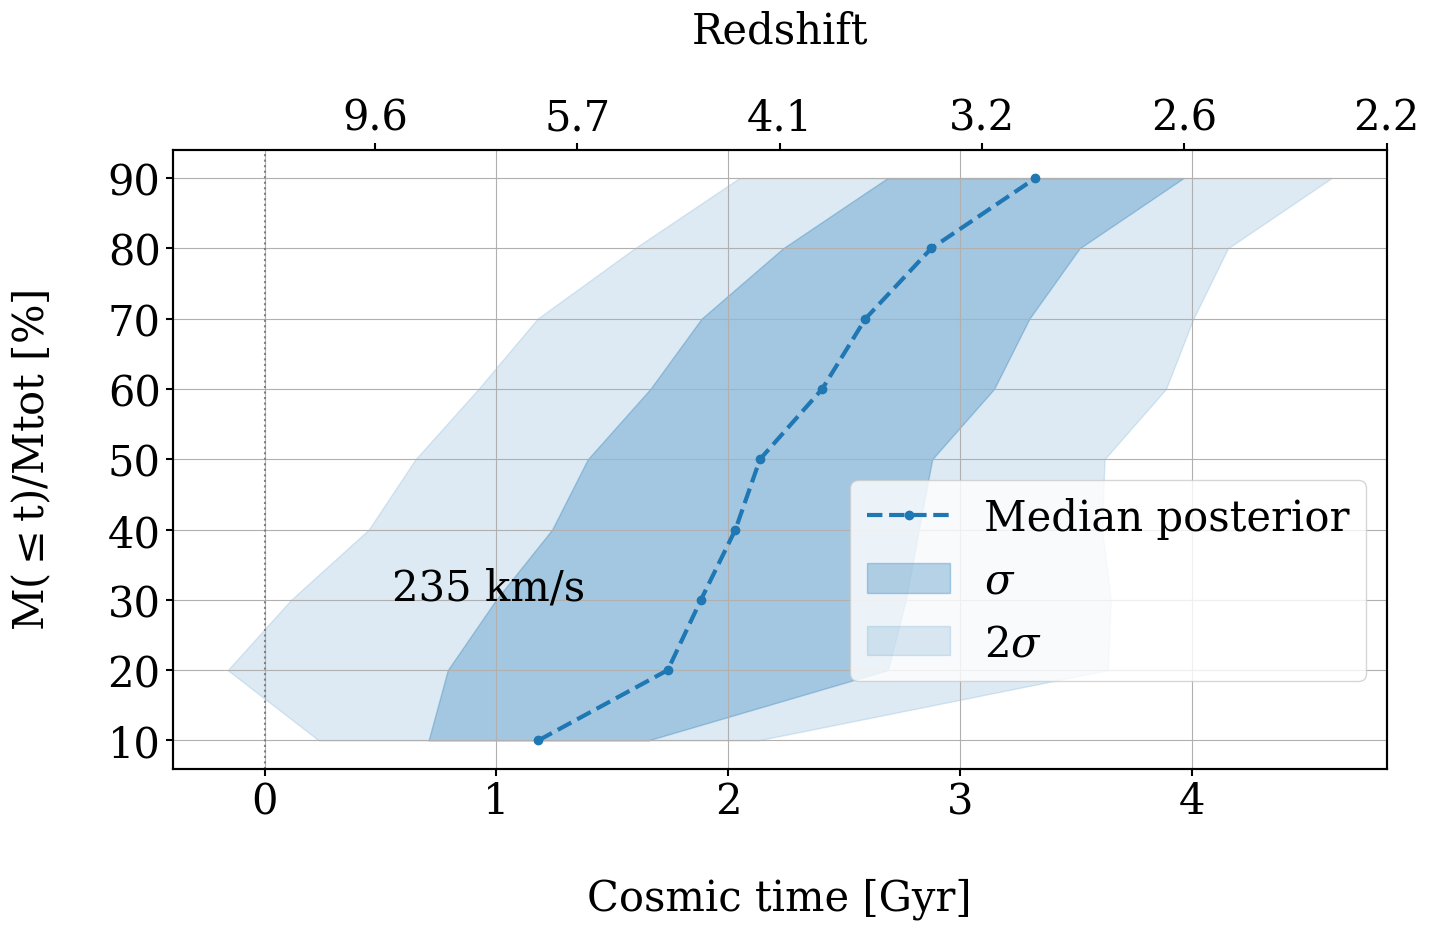

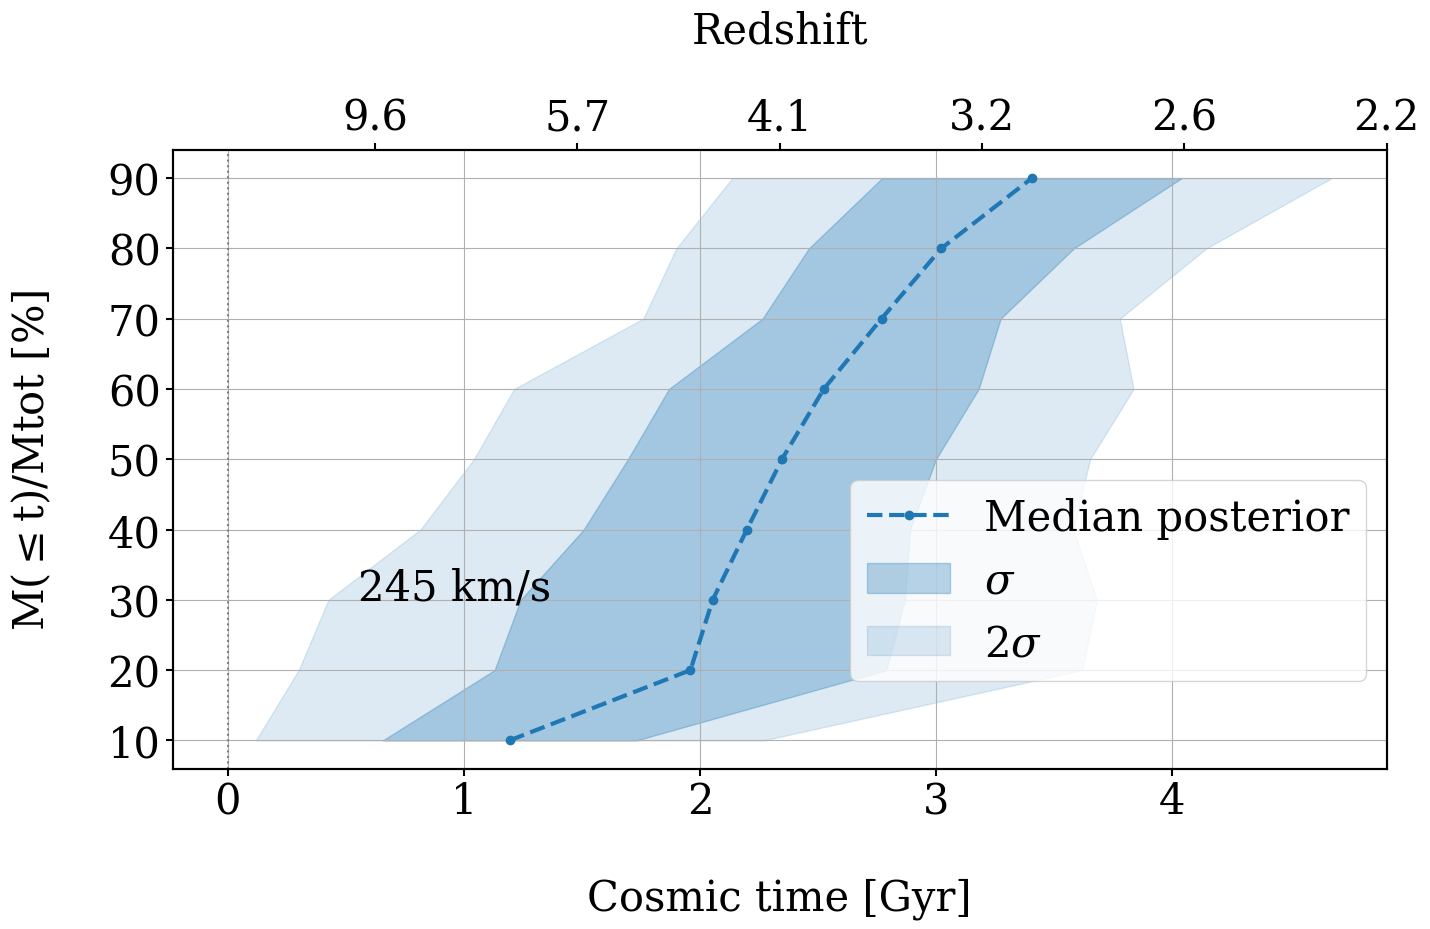

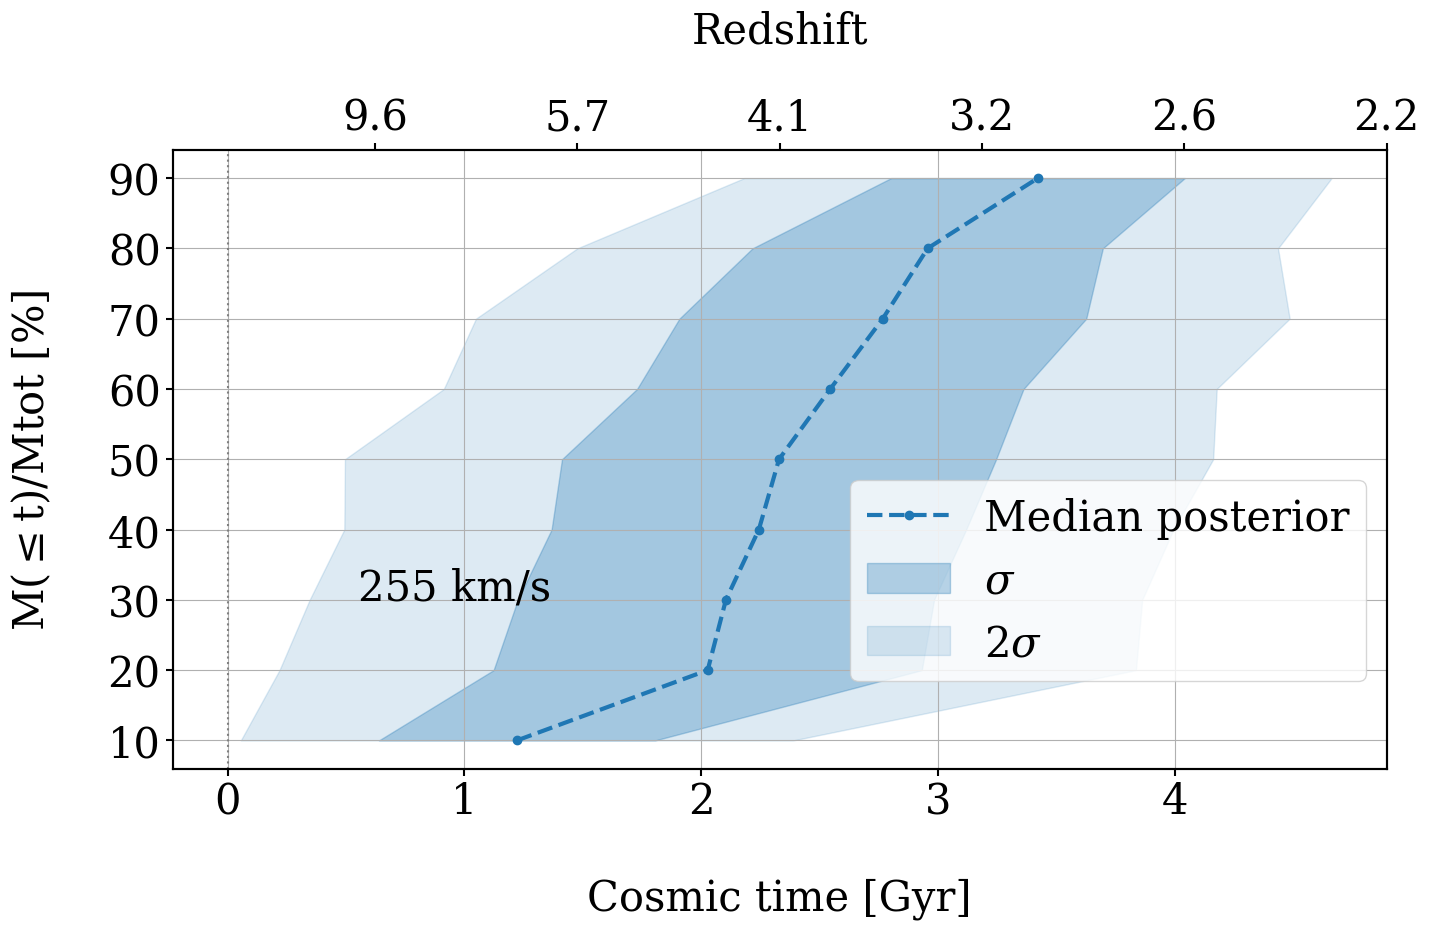

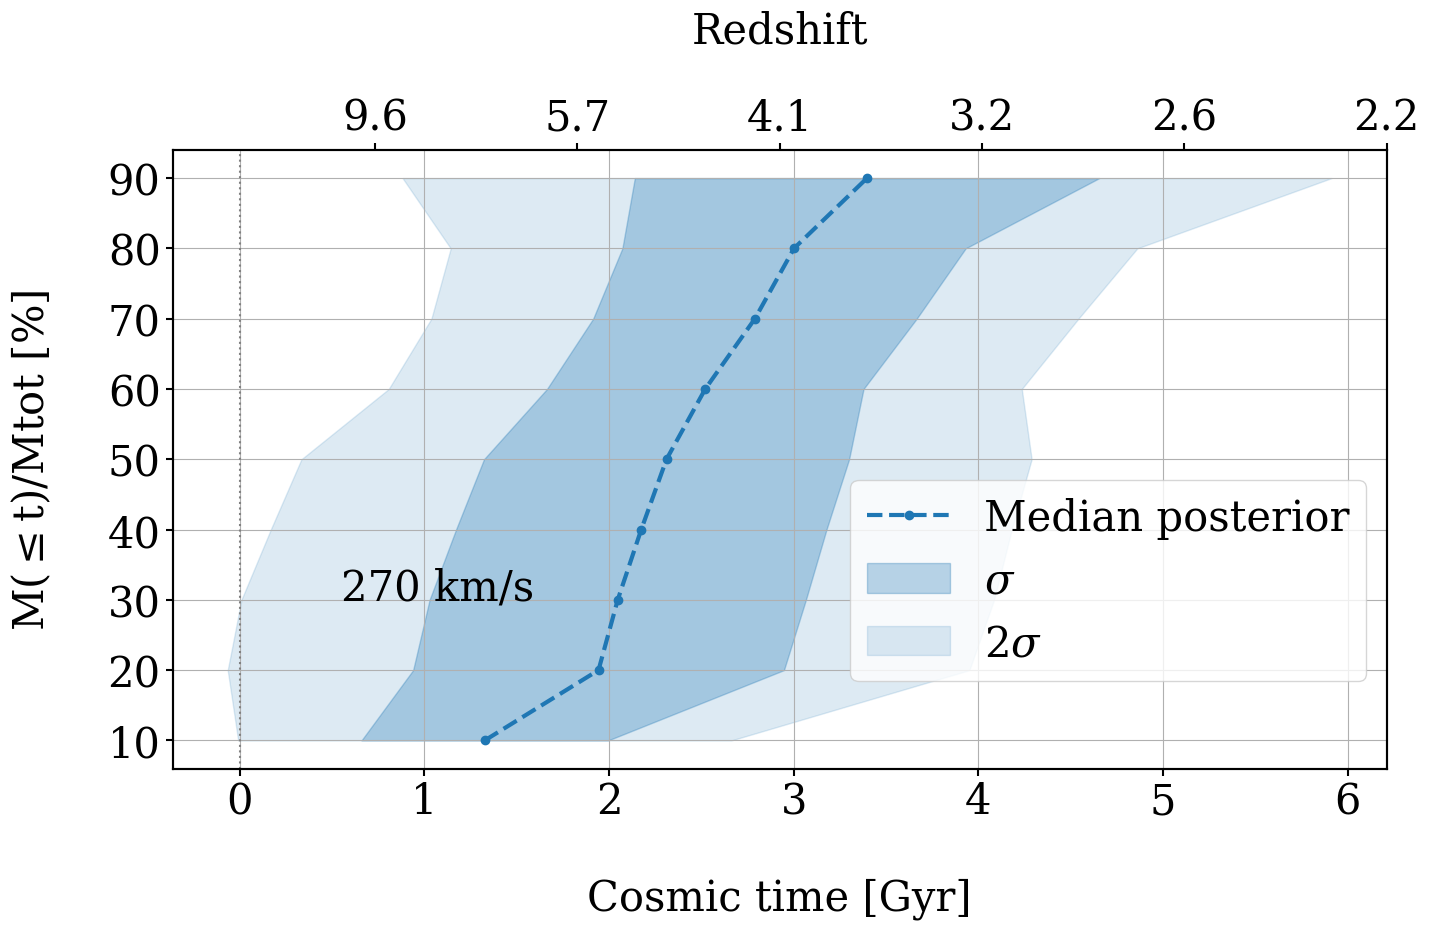

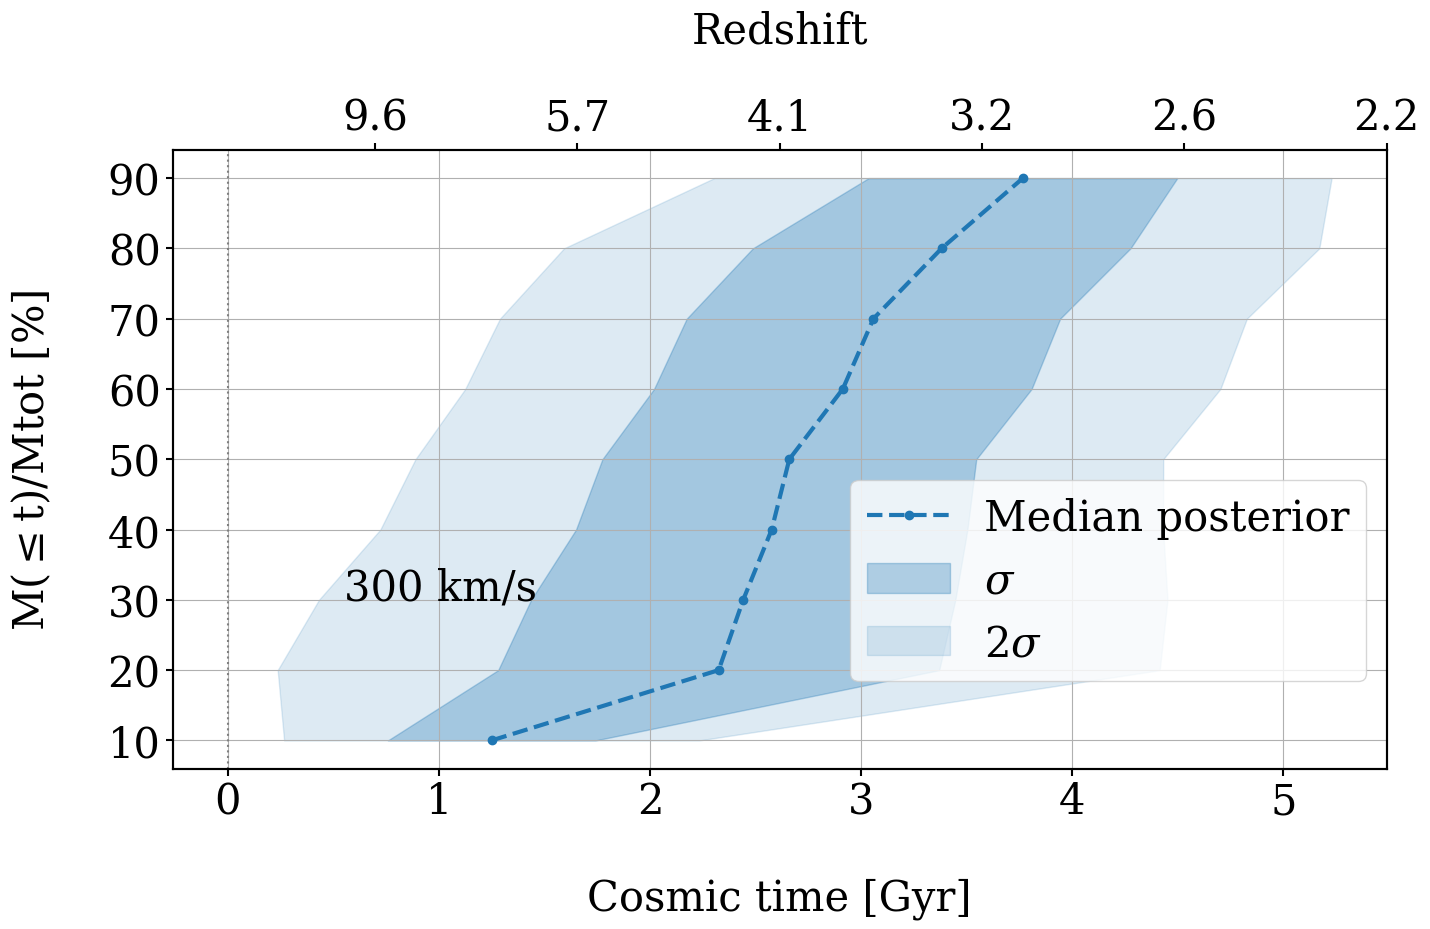

In [30]:
def plot_percentile_distribution(preds_mean=post_median,preds_stds=post_stds,index_list=range(18)):

    """Plot percentile predictions with their uncertainites for observed stacks of ETGs

    Parameters
    ----------
    preds_mean: array, size (len(index_list),10)
        Median of the posteriors predicted for the 10 features

    preds_stds: array, size (len(index_list),10)
        Standard deviations of the posteriors predicted for the 10 features
    
    index_list: list, default size (18)
        Indeces of the observations
    """
    for k,j in enumerate(index_list):
                
            pred_mean=preds_mean[j]
            pred_stds=preds_stds[j]

            fig,ax=plt.subplots()
            ax.plot(pred_mean[:9],np.arange(10,100,10),'o--',color='tab:blue',label='Median posterior',lw=3)
            
           #plt.title('Percentiles galaxy ' +str(int(sigma_gal[j]))+' km/s'+'\n')
            plt.text(0.55,30,str(int(sigma_gal[j]))+' km/s')
            plt.xlabel('\n'+'Cosmic time [Gyr]')
            plt.ylabel('M($\leq$t)/Mtot [%]'+'\n')
            plt.axvline(0,0,1,ls=':',color='grey')

            ax2 = ax.twiny()
        
            xt=np.arange(0,3.5,0.5)
            xl=z(xt[1:])
            ax2.set_xticks(xt[1:],labels=xl)
            ax2.set_xlabel('Redshift'+'\n')

            ax.fill_betweenx(np.arange(10,100,10),pred_mean[:9]+pred_stds[:9],pred_mean[:9]-pred_stds[:9],color='tab:blue',alpha=0.3,label='$\\sigma$')
            
            ax.fill_betweenx(np.arange(10,100,10),pred_mean[:9]+2*pred_stds[:9],pred_mean[:9]-2*pred_stds[:9],color= 'tab:blue',alpha=0.15,label='$2\\sigma$')
            


            ax.legend(bbox_to_anchor=(1, 0.5))

            #ax.set_xlim(0,3)

            ax.set_yticks(np.arange(10,100,10))
            ax.grid()
            

            plt.tight_layout()
            #plt.savefig('pred_gal_'+str(int(sigma_gal[j]))+'.jpg')
            plt.show()


plot_percentile_distribution()

Load pPXF predictions (weigths for MILES SSP spectra of different ages and metallicities)

In [38]:
import os

ppxf_dir='ages_ppxf'
files= sorted(os.listdir(ppxf_dir))
print(files)
ages=[]
weights=[]
for f in files[:]:
    data=np.loadtxt('./'+ppxf_dir+'/'+f)
    ages.append(14-data[:,0]) #First step to transform from lookback time to cosmic time
    weights.append(data[:,1])

dir_ppxf='metallicities_ppxf'
files= sorted(os.listdir(dir_ppxf))
met_ppxf=[]
met_weights=[]
for f in files[:]:
    data=np.loadtxt('./'+dir_ppxf+'/'+f)
    met_ppxf.append(data[:,0])
    met_weights.append(data[:,1])
    

['Ages_weights_100.00_110.00.dat', 'Ages_weights_110.00_120.00.dat', 'Ages_weights_120.00_130.00.dat', 'Ages_weights_130.00_140.00.dat', 'Ages_weights_140.00_150.00.dat', 'Ages_weights_150.00_160.00.dat', 'Ages_weights_160.00_170.00.dat', 'Ages_weights_170.00_180.00.dat', 'Ages_weights_180.00_190.00.dat', 'Ages_weights_190.00_200.00.dat', 'Ages_weights_200.00_210.00.dat', 'Ages_weights_210.00_220.00.dat', 'Ages_weights_220.00_230.00.dat', 'Ages_weights_230.00_240.00.dat', 'Ages_weights_240.00_250.00.dat', 'Ages_weights_250.00_260.00.dat', 'Ages_weights_260.00_280.00.dat', 'Ages_weights_280.00_320.00.dat']


Compute the stellar mass percentiles associated to the predictions of pPXF

In [35]:
percent_ppxf=[]
#Second step to transform from lookback time to cosmic time
ages_ok=np.array(ages)[:,::-1] 
weights_ok=np.array(weights)[:,::-1]
for j in range(18):
    mcurve=weights_ok[j]
    m=[]
    percent=[]
    for a in range(len(mcurve)):
        m.append(np.sum(mcurve[:a+1]))
    for b in range(1,10):
        ind=np.argmin(abs(np.array(m)-b/10))
        percent.append(ages_ok[j][ind])
    percent_ppxf.append(percent)

Show two examples of the mass curves (non-cumulative) predicted by pPXF

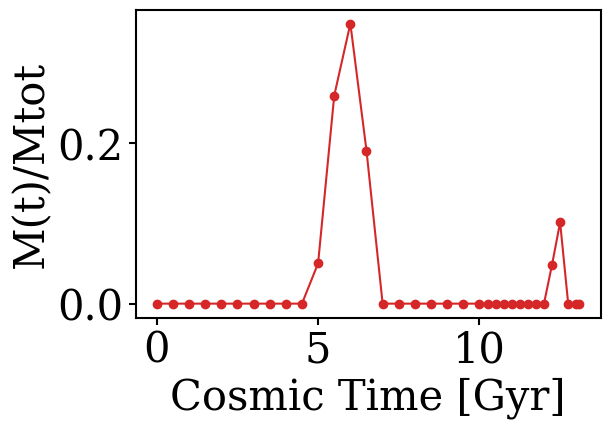

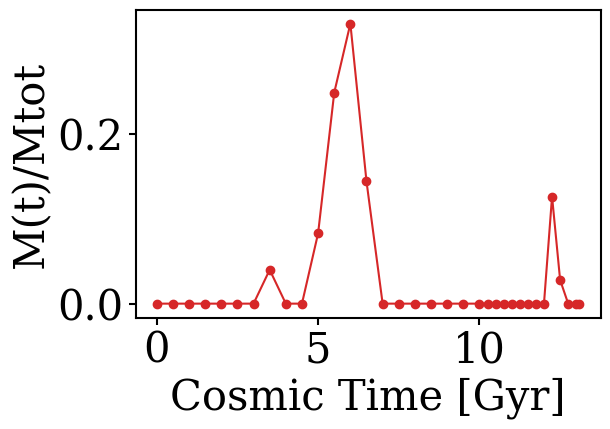

In [10]:
for i in range(2):
    plt.figure(figsize=(6,4))
    plt.plot(ages_ok[i],weights_ok[i],'-o',color='tab:red')
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel('M(t)/Mtot')
    plt.show()

Define format for the metallicity values (predicted by pPXF and by our model )

In [39]:
met_ppxf=np.array(met_ppxf)
met_weights=np.array(met_weights)
np.set_printoptions(precision=2,floatmode='fixed')
mets_ppxf=np.around(np.sum(met_ppxf*met_weights,axis=1),2)
mets_you=np.around(post_median[:,-1],2)
mets_you_err=np.around(2*post_stds[:,-1],2)

Plot of percentiles predicted by our model and by pPXF, including metallicity values

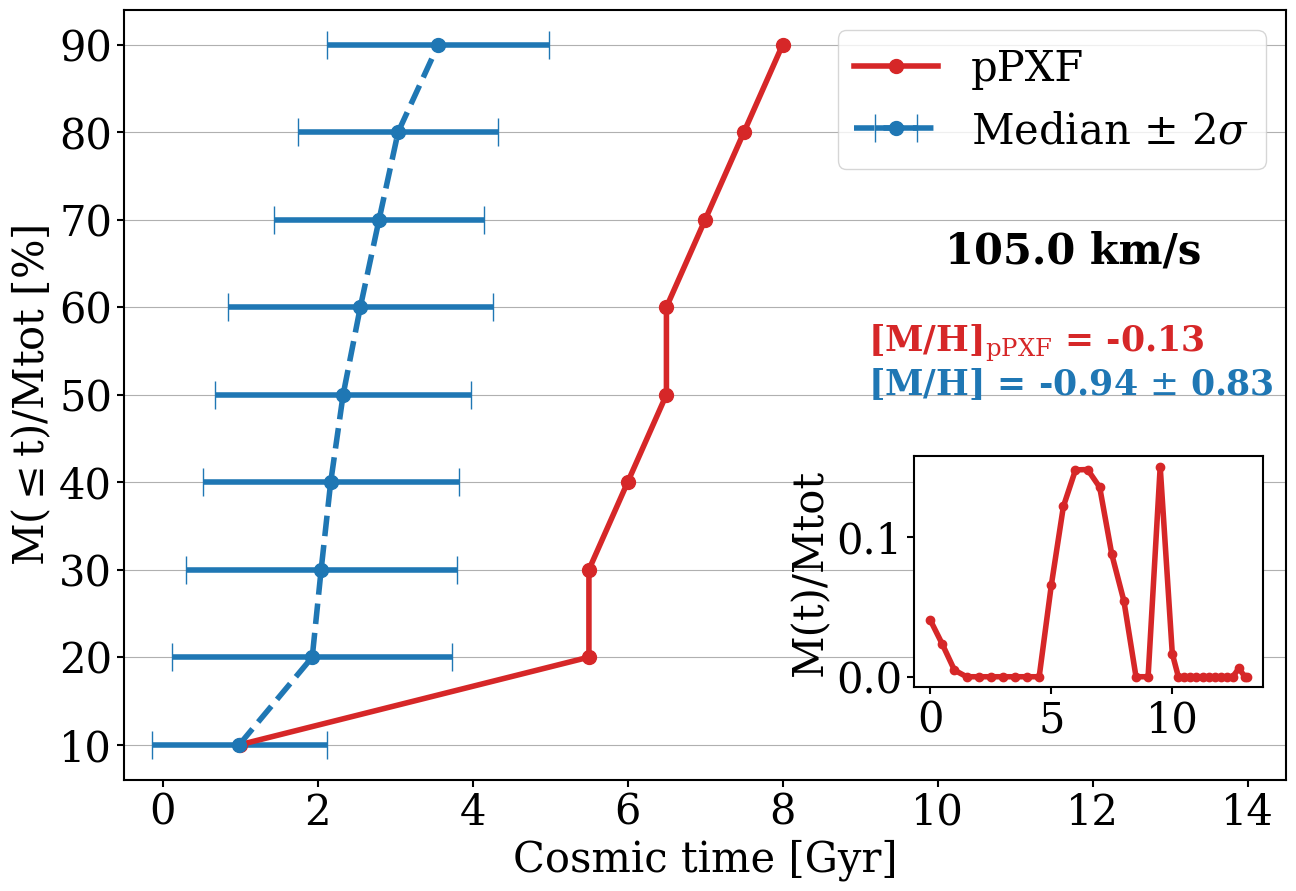

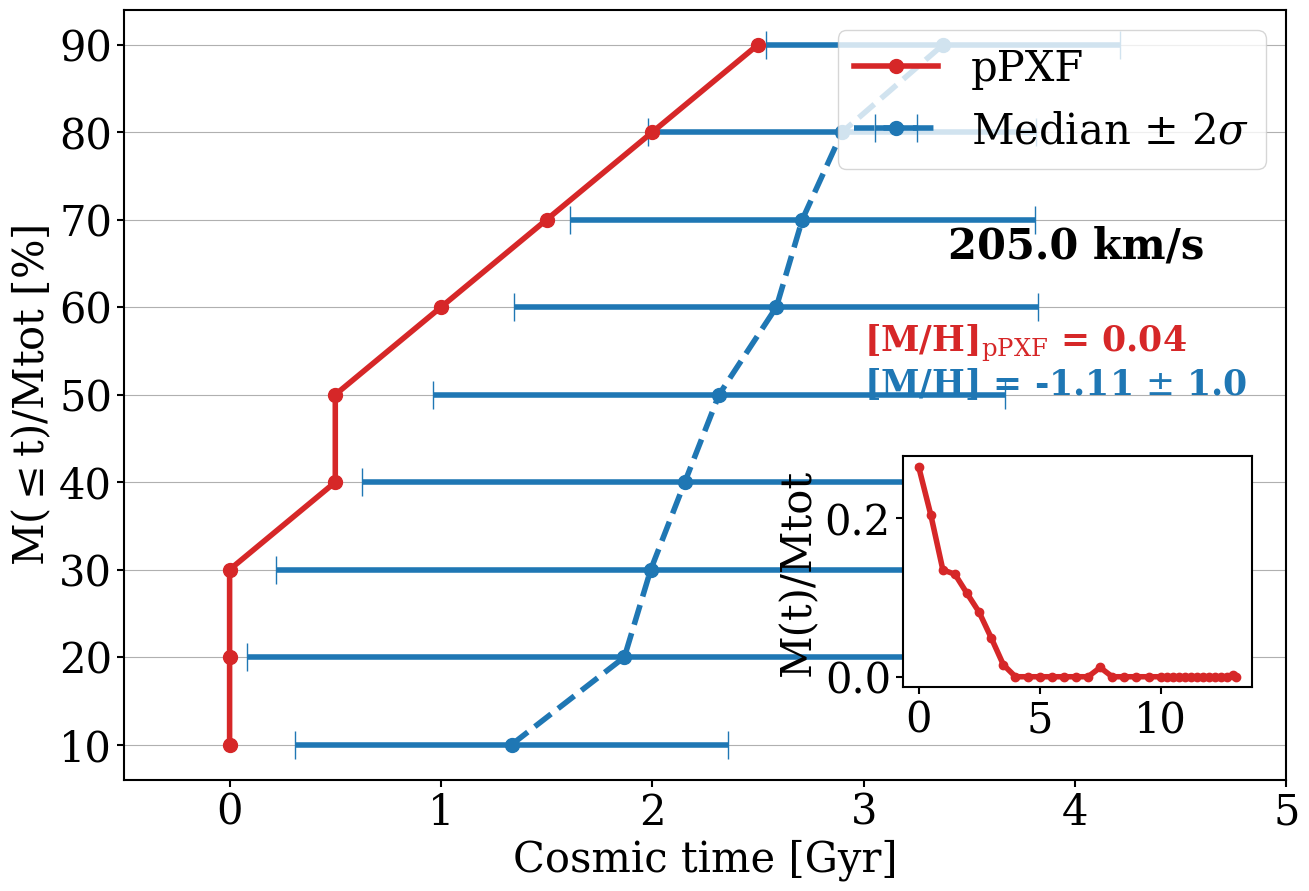

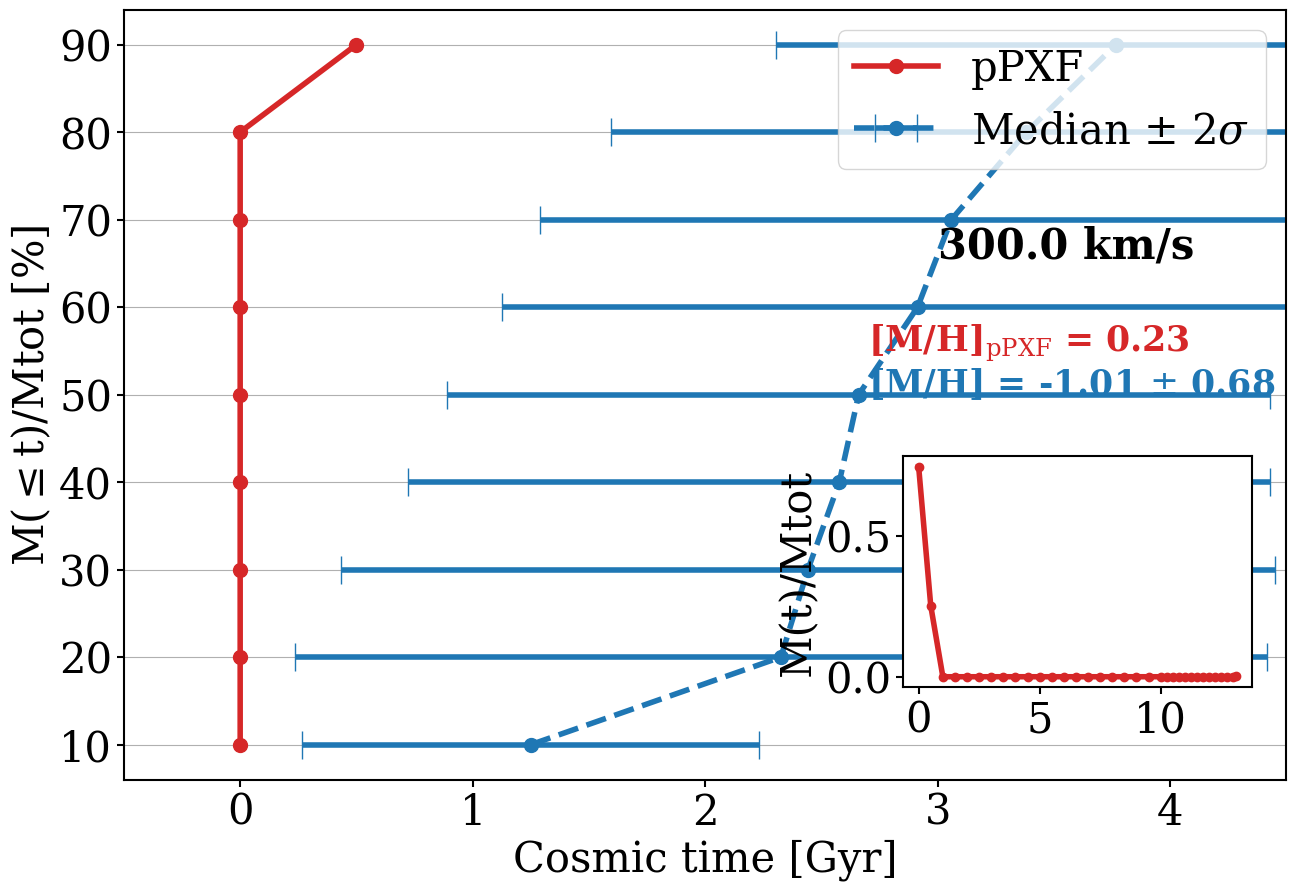

In [40]:
np.set_printoptions(precision=2,floatmode='fixed')

def plot_observations(preds_mean=post_median,preds_stds=post_stds,index_list=[0,10,17]):

    for k,j in enumerate(index_list):  
        pred_mean=preds_mean[j]
        pred_stds=preds_stds[j]

        met_ppxf=mets_ppxf[j]
        met_you=mets_you[j]
        met_you_err=mets_you_err[j] 

        fig=plt.figure()
        ax = fig.add_subplot(111)

        plt.errorbar(pred_mean[:9],np.arange(10,100,10),xerr=2*pred_stds[:9],fmt='o--',color='tab:blue',label='Median $\\pm$ 2$\\sigma$',lw=4,ms=10,capsize=10)

        plt.plot(percent_ppxf[j],np.arange(10,100,10),'-o',label='pPXF',c='tab:red',lw=4,ms=10)
        
        

        plt.legend(loc='upper right', frameon=True)
        plt.xlabel('Cosmic time [Gyr]')
        plt.ylabel('M($\leq$t)/Mtot [%]')
        
        if k==0:
            plt.text(10.1,65,str(sigma_gal[j])+' km/s',fontsize=30,weight='bold')
            plt.text(9.1,50,'[M/H] = '+str(met_you)+' $\\pm$ '+str(met_you_err),color='tab:blue',weight='bold',fontsize=25)
            plt.text(9.1,55,'[M/H]$_{\\rm{pPXF}}$ = '+str(met_ppxf),color='tab:red',weight='bold',fontsize=25)
            plt.xlim(-0.5,14.5)

            axin = ax.inset_axes([0.68, 0.12, 0.3, 0.3])


        elif k==1:

            plt.text(3.4,60,str(sigma_gal[j])+' km/s'+'\n',fontsize=30,weight='bold')
            plt.text(3.0,50,'[M/H] = '+str(met_you)+' $\\pm$ '+str(met_you_err),color='tab:blue',weight='bold',fontsize=25)
            plt.text(3.0,55,'[M/H]$_{\\rm{pPXF}}$ = '+str(met_ppxf),color='tab:red',weight='bold',fontsize=25)
            plt.xlim(-0.5,5)
            axin = ax.inset_axes([0.67, 0.12, 0.3, 0.3])


        else:
            plt.text(3.0,60,str(sigma_gal[j])+' km/s'+'\n',fontsize=30,weight='bold')
            plt.text(2.7,50,'[M/H] = '+str(met_you)+' $\\pm$ '+str(met_you_err),color='tab:blue',weight='bold',fontsize=25)
            plt.text(2.7,55,'[M/H]$_{\\rm{pPXF}}$ = '+str(met_ppxf),color='tab:red',weight='bold',fontsize=25)
            plt.xlim(-0.5,4.5)
            axin = ax.inset_axes([0.67, 0.12, 0.3, 0.3])

        plt.grid(axis='y')
        
        axin.plot(ages_ok[j],weights_ok[j],'-o',color='tab:red',lw=4)
        #axin.set_title(str(sigma_gal[j])+' km/s'+'\n',fontsize=30,weight='bold')
        #axin.set_xlabel('Cosmic Time [Gyr]')
        axin.set_ylabel('M(t)/Mtot')
        axin.set_xticks([0,5.0,10.0])
        #plt.savefig('pred_ppxf_'+str(j)+'.pdf')
        plt.show()

    

plot_observations()
    
    

The same plots without the inner frames showing the non-cumulative mass curves predicted by pPXF

In [37]:
np.set_printoptions(precision=2,floatmode='fixed')

def plot_observations(preds_mean=post_median,preds_stds=post_stds,index_list=[0,10,17]):
    
    #range(18)
    
    for k,j in enumerate(index_list):  
        pred_mean=preds_mean[j]
        pred_stds=preds_stds[j]

        met_ppxf=mets_ppxf[j]
        met_you=mets_you[j]
        met_you_err=mets_you_err[j] 

        fig=plt.figure()
        ax = fig.add_subplot(111)

        plt.errorbar(pred_mean[:9],np.arange(10,100,10),xerr=2*pred_stds[:9],fmt='o--',color='tab:blue',label='Median $\\pm$ 2$\\sigma$',lw=4,ms=10,capsize=10)

        plt.plot(percent_ppxf[j],np.arange(10,100,10),'-o',label='pPXF',c='tab:red',lw=4,ms=10)
        
        

        plt.legend(loc='lower right', frameon=True)
        plt.xlabel('Cosmic time [Gyr]')
        plt.ylabel('M($\leq$t) / M$_\\mathrm{tot}$ [%]')
        
        if k==0:
            plt.text(10.1,65,str(sigma_gal[j])+' km/s',fontsize=30,weight='bold')
            plt.text(9.1,43,'[M/H] = '+str(met_you)+' $\\pm$ '+str(met_you_err),color='tab:blue',weight='bold',fontsize=25)
            plt.text(9.5,50,'[M/H]$_{\\rm{pPXF}}$ = '+str(met_ppxf),color='tab:red',weight='bold',fontsize=25)
            plt.xlim(-0.5,14.5)

            #axin = ax.inset_axes([0.68, 0.12, 0.3, 0.3])


        elif k==1:

            plt.text(1.7,55,str(sigma_gal[j])+' km/s'+'\n',fontsize=30,weight='bold')
            plt.text(1.5,38,'[M/H] = '+str(met_you)+' $\\pm$ '+str(met_you_err),color='tab:blue',weight='bold',fontsize=25)
            plt.text(1.6,45,'[M/H]$_{\\rm{pPXF}}$ = '+str(met_ppxf),color='tab:red',weight='bold',fontsize=25)
            #plt.xlim(-0.5,5)
            #axin = ax.inset_axes([0.67, 0.12, 0.3, 0.3])


        else:
            plt.text(1.3,55,str(sigma_gal[j])+' km/s'+'\n',fontsize=30,weight='bold')
            plt.text(1.1,38,'[M/H] = '+str(met_you)+' $\\pm$ '+str(met_you_err),color='tab:blue',weight='bold',fontsize=25)
            plt.text(1.2,45,'[M/H]$_{\\rm{pPXF}}$ = '+str(met_ppxf),color='tab:red',weight='bold',fontsize=25)
            #plt.xlim(-0.5,4.5)
            #axin = ax.inset_axes([0.67, 0.12, 0.3, 0.3])

        #plt.grid(axis='y')
        
        """axin.plot(ages_ok[j],weights_ok[j],'-o',color='tab:red',lw=4)
        #axin.set_title(str(sigma_gal[j])+' km/s'+'\n',fontsize=30,weight='bold')
        #axin.set_xlabel('Cosmic Time [Gyr]')
        axin.set_ylabel('M(t)/Mtot')
        axin.set_xticks([0,5.0,10.0])"""
        plt.savefig('pred_ppxf2_'+str(j)+'.pdf')
        plt.show()

    

plot_observations()
    
    

NameError: name 'mets_ppxf' is not defined

Plot showing the 18 predictions for the percentiles of stellar mass of the stacks of ETGs

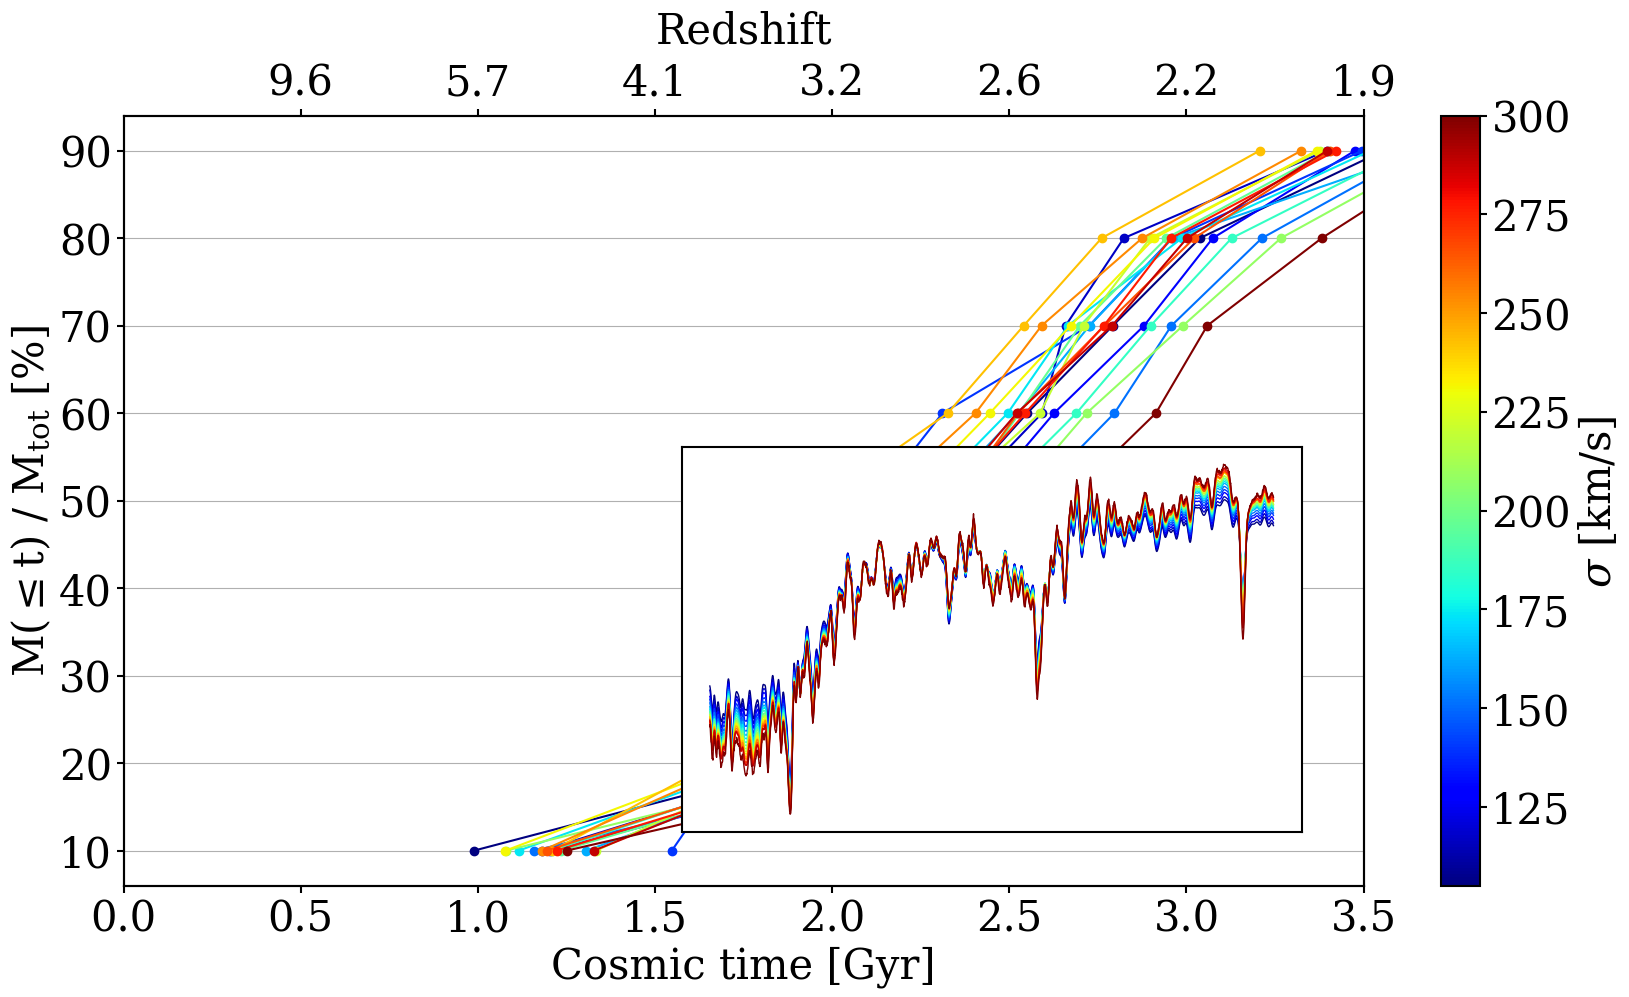

In [41]:

mpl.rcParams["figure.figsize"] = (20,10)

w=np.arange(4023,6001)

colors=plt.cm.jet(np.linspace(0,1,18))
fig,ax=plt.subplots()

for k,j in enumerate(range(18)):
            
    ax.plot(post_median[j][:9],np.arange(10,100,10),'o-',color=colors[k])
    plt.scatter(post_median[j][:9],np.arange(10,100,10),marker='None',c=sigma_gal[k]*np.ones((9,)),cmap='jet')


plt.xlabel('Cosmic time [Gyr]')
plt.ylabel('M($\leq$t) / M$_{\\rm tot}$ [%]')
ax2 = ax.twiny()
xt=np.arange(0,4,0.5)
xl=z(xt[1:])
ax2.set_xticks(xt[1:],labels=xl)
ax2.set_xlabel('Redshift',labelpad=14)
ax.set_xlim(0,3.5)
ax.set_yticks(np.arange(10,100,10))
ax.grid(axis='y')

axin = ax.inset_axes([0.45, 0.07, 0.5, 0.5])
for i in range(18):
    axin.plot(w,seds[i,:],c=colors[i],lw=1)
axin.set_yticks([])
axin.set_xticks([])

plt.colorbar(label='$\\sigma$ [km/s]')
plt.clim(105,300)
#plt.savefig('pred_gal_full.pdf')
plt.show()

Create a dataframe with the predictions of our model and transform it into a Latex table

In [42]:
import pandas as pd

files= sorted(os.listdir('/Users/patriglesiasnavarro/Desktop/ULL/Terminado/Master/Segundo/TFM/programas/github/SBI_SFHs/observations_no_ssfr/obs/'))[2:]


arrs=[]
for f in files:
    arrs.append(str(int(float(f[6:12])))+'-'+str(int(float(f[13:19])))) #just names of files from which we get the ranges of velocity dispersion

label=['P'+str(i)+'\%'+' [Gyr]' for i in np.arange(10,100,10)]
label.append('[M/H]')


data=np.zeros((18,10),dtype=object)

for i in range(18):
    for j in range(10):
        data[i,j]=str(np.around(post_median[i,j],2))+'$\pm$'+str(np.around(post_stds[i,j],2))

df = pd.DataFrame(data,columns=[label[i] for i in range(10)], index = [arrs[i] for i in range(18)])

df

P10\% [Gyr]    P20\% [Gyr]    P30\% [Gyr]    P40\% [Gyr]  \
100-110  0.99$\pm$0.56   1.93$\pm$0.9  2.04$\pm$0.87  2.17$\pm$0.82   
110-120  1.18$\pm$0.49  1.97$\pm$0.86  2.08$\pm$0.82  2.23$\pm$0.76   
120-130   1.2$\pm$0.61   2.16$\pm$1.0  2.26$\pm$0.94  2.35$\pm$0.87   
130-140  1.55$\pm$0.59  1.72$\pm$0.83  1.81$\pm$0.79  1.95$\pm$0.76   
140-150  1.16$\pm$0.49   2.2$\pm$0.99  2.34$\pm$0.91  2.46$\pm$0.82   
150-160  1.31$\pm$0.61  1.98$\pm$1.02  2.06$\pm$0.95  2.17$\pm$0.83   
160-170  1.11$\pm$0.62   1.8$\pm$0.84  1.89$\pm$0.83  2.05$\pm$0.72   
170-180  1.21$\pm$0.55   1.95$\pm$1.2   2.15$\pm$1.1  2.32$\pm$0.92   
180-190   1.23$\pm$0.5  2.07$\pm$0.98   2.18$\pm$0.9  2.28$\pm$0.81   
190-200  1.08$\pm$0.44  2.09$\pm$1.26   2.2$\pm$1.11  2.33$\pm$0.99   
200-210  1.33$\pm$0.51  1.87$\pm$0.89  1.99$\pm$0.89  2.15$\pm$0.76   
210-220  1.08$\pm$0.63  1.73$\pm$0.88  1.84$\pm$0.86  2.01$\pm$0.85   
220-230  1.21$\pm$0.64  1.67$\pm$1.04   1.74$\pm$1.0  1.87$\pm$0.94   
230-240  1.18$\pm$0.47  1.74$\pm$0.95  1.88$\pm$0.88  2.03$\pm$0.79   
240-250  1.19$\pm$0.54  1.96$\pm$0.83  2.05$\pm$0.81   2.2$\pm$0.69   
250-260  1.22$\pm$0.58   2.03$\pm$0.9   2.1$\pm$0.88  2.24$\pm$0.88   
260-280  1.33$\pm$0.67   1.94$\pm$1.0  2.05$\pm$1.02   2.17$\pm$1.0   
280-320  1.25$\pm$0.49  2.33$\pm$1.04   2.44$\pm$1.0  2.58$\pm$0.93   

           P50\% [Gyr]    P60\% [Gyr]    P70\% [Gyr]    P80\% [Gyr]  \
100-110  2.33$\pm$0.83  2.55$\pm$0.85  2.79$\pm$0.68  3.04$\pm$0.65   
110-120  2.36$\pm$0.73  2.59$\pm$0.71  2.66$\pm$0.67  2.82$\pm$0.56   
120-130  2.42$\pm$0.81  2.63$\pm$0.77  2.88$\pm$0.61  3.07$\pm$0.62   
130-140  2.12$\pm$0.72  2.31$\pm$0.71  2.73$\pm$0.56  2.96$\pm$0.56   
140-150  2.55$\pm$0.76   2.8$\pm$0.71  2.96$\pm$0.64  3.21$\pm$0.52   
150-160  2.29$\pm$0.76  2.53$\pm$0.74  2.73$\pm$0.71  2.96$\pm$0.65   
160-170   2.25$\pm$0.7   2.5$\pm$0.72  2.67$\pm$0.55  2.99$\pm$0.62   
170-180  2.44$\pm$0.82  2.69$\pm$0.79   2.9$\pm$0.76   3.13$\pm$0.7   
180-190  2.35$\pm$0.76  2.53$\pm$0.74   2.7$\pm$0.71  2.94$\pm$0.65   
190-200  2.51$\pm$0.91  2.72$\pm$0.88  2.99$\pm$0.82  3.27$\pm$0.66   
200-210  2.32$\pm$0.68  2.59$\pm$0.62  2.71$\pm$0.55   2.9$\pm$0.46   
210-220   2.2$\pm$0.83  2.45$\pm$0.83  2.67$\pm$0.76  2.91$\pm$0.71   
220-230  1.97$\pm$0.91  2.33$\pm$0.86  2.54$\pm$0.91  2.76$\pm$0.84   
230-240  2.14$\pm$0.74   2.4$\pm$0.74  2.59$\pm$0.71  2.87$\pm$0.64   
240-250  2.35$\pm$0.65  2.52$\pm$0.66   2.77$\pm$0.5  3.02$\pm$0.56   
250-260  2.33$\pm$0.92  2.54$\pm$0.82  2.77$\pm$0.86  2.96$\pm$0.74   
260-280  2.31$\pm$0.99  2.52$\pm$0.86  2.79$\pm$0.88   3.0$\pm$0.93   
280-320  2.66$\pm$0.89  2.91$\pm$0.89  3.06$\pm$0.88  3.38$\pm$0.89   

           P90\% [Gyr]           [M/H]  
100-110  3.56$\pm$0.72  -0.94$\pm$0.41  
110-120   3.4$\pm$0.68  -0.93$\pm$0.34  
120-130  3.48$\pm$0.55  -0.97$\pm$0.51  
130-140   3.5$\pm$0.53  -1.03$\pm$0.48  
140-150  3.66$\pm$0.62  -0.91$\pm$0.47  
150-160  3.68$\pm$0.53  -0.96$\pm$0.48  
160-170   3.52$\pm$0.7  -0.94$\pm$0.48  
170-180   3.62$\pm$0.6  -0.84$\pm$0.54  
180-190   3.4$\pm$0.61  -0.91$\pm$0.36  
190-200  3.72$\pm$0.57  -0.86$\pm$0.31  
200-210  3.38$\pm$0.42   -1.11$\pm$0.5  
210-220  3.37$\pm$0.76  -1.05$\pm$0.41  
220-230   3.21$\pm$0.8  -1.06$\pm$0.58  
230-240  3.32$\pm$0.64  -1.08$\pm$0.48  
240-250  3.41$\pm$0.63  -0.92$\pm$0.44  
250-260  3.42$\pm$0.62  -1.09$\pm$0.37  
260-280   3.4$\pm$1.26  -0.99$\pm$0.43  
280-320  3.77$\pm$0.73  -1.01$\pm$0.34

In [89]:
print(df.to_latex(escape=False))

\begin{tabular}{lllllllllll}
\toprule
{} &    P10\% [Gyr] &    P20\% [Gyr] &    P30\% [Gyr] &    P40\% [Gyr] &    P50\% [Gyr] &    P60\% [Gyr] &    P70\% [Gyr] &    P80\% [Gyr] &    P90\% [Gyr] &           [M/H] \\
\midrule
100-110 &  0.42$\pm$0.22 &   0.6$\pm$0.26 &   0.78$\pm$0.3 &  0.97$\pm$0.33 &  1.21$\pm$0.34 &   1.5$\pm$0.37 &  1.81$\pm$0.42 &  2.27$\pm$0.45 &  2.89$\pm$0.63 &   0.11$\pm$0.24 \\
110-120 &  0.36$\pm$0.22 &  0.54$\pm$0.26 &  0.69$\pm$0.29 &  0.87$\pm$0.32 &  1.12$\pm$0.32 &  1.39$\pm$0.35 &  1.67$\pm$0.41 &   2.1$\pm$0.46 &  2.63$\pm$0.66 &   0.13$\pm$0.23 \\
120-130 &  0.32$\pm$0.21 &  0.47$\pm$0.26 &   0.6$\pm$0.29 &  0.75$\pm$0.32 &  0.95$\pm$0.33 &  1.19$\pm$0.37 &  1.41$\pm$0.45 &  1.79$\pm$0.52 &  2.21$\pm$0.75 &  -0.05$\pm$0.32 \\
130-140 &  0.23$\pm$0.17 &  0.34$\pm$0.22 &  0.43$\pm$0.26 &  0.55$\pm$0.28 &  0.72$\pm$0.29 &  0.93$\pm$0.33 &   1.08$\pm$0.4 &  1.38$\pm$0.48 &   1.66$\pm$0.7 &   -0.12$\pm$0.4 \\
140-150 &  0.16$\pm$0.13 &  0.26$\pm$0.18 &  0.3

/var/folders/26/90klcxjd1_x9q0l8mz3tx1g00000gn/T/ipykernel_30688/4079661275.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False))
